In [16]:
import os
import sys
import torch
import pickle
import copy
import time
import numpy as np
homedir = '../Software'
sys.path.insert(0,  homedir)
from LogicRBM.rbm import RBM, MultRBM
import RBM.utils as utils
from SAT.SATrbm import SATrbm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
sns.set()

In [17]:
matplotlib.__version__

'3.1.3'

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.sans-serif'] = 'Helvetica'
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})
sns.set_style('dark', {'axes.grid': False,})

c  simple_v3_c4.cnf
c
vars: 3 clauses: 4
var: 1 inds: [0, 3]
var: 2 inds: [1, 8]
var: 3 inds: [2, 7]
intial setting of outbits tensor([0, 1, 2]) len: 3
[3, 8, 6, 7]
outbits before collapse tensor([0, 1, 2]) len: 3
outbits after collapse tensor([0, 1, 2]) len: 3
[0.125 0.    0.    0.    0.    0.    0.125 0.    0.    0.    0.125 0.
 0.    0.125 0.    0.    0.    0.    0.125 0.    0.    0.125 0.    0.
 0.    0.125 0.    0.    0.    0.    0.    0.125]
tensor([0, 1, 3, 4, 8])
[0.10877414666590172, 0.006605070108371409, 0.0015811715433031882, 9.601386998074439e-05, 0.001548964588425402, 0.00011185550486213225, 0.10655770829627624, 0.007694926344049374, 0.001538638114337568, 0.0001110159981096365, 0.1058489222441424, 0.0076371663858611424, 0.00538508337440002, 0.10130878041758155, 7.827872937110583e-05, 0.0014726417984402551, 0.0015386263832979977, 0.00011101445081379818, 0.10584731462096546, 0.007637113459028798, 0.005385071731887131, 0.10130877956896522, 7.827872941551475e-05, 0.00147264180

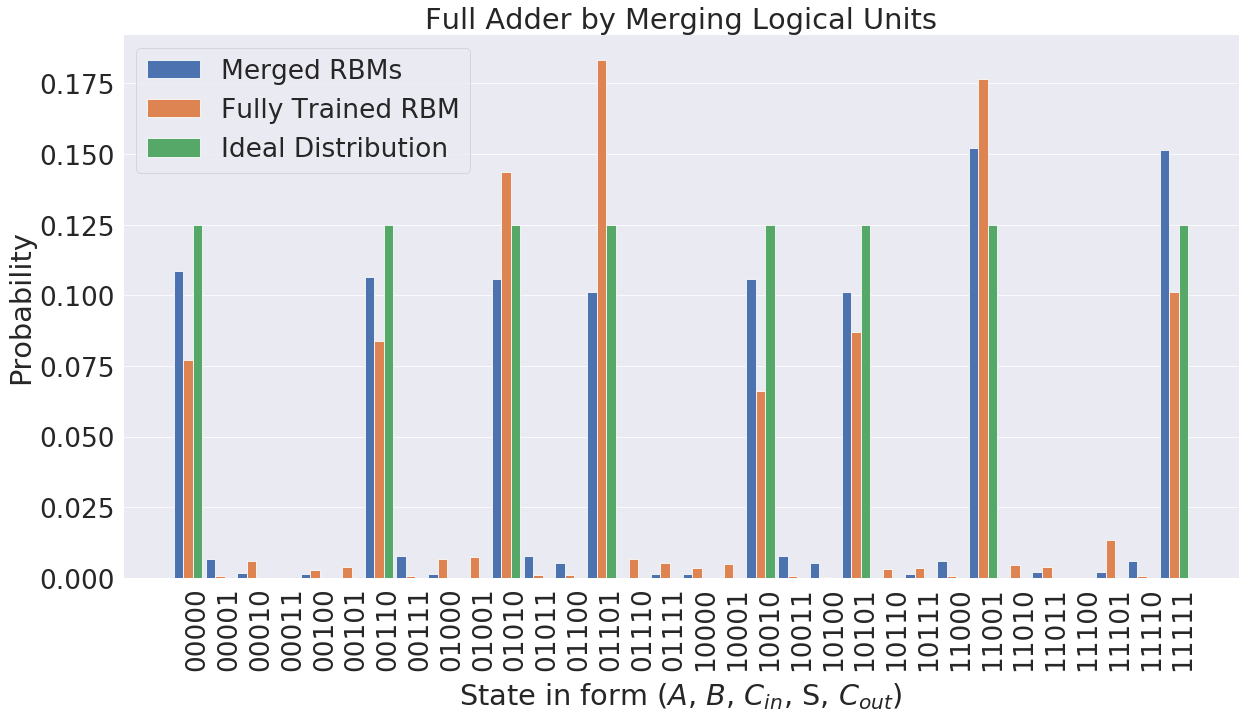

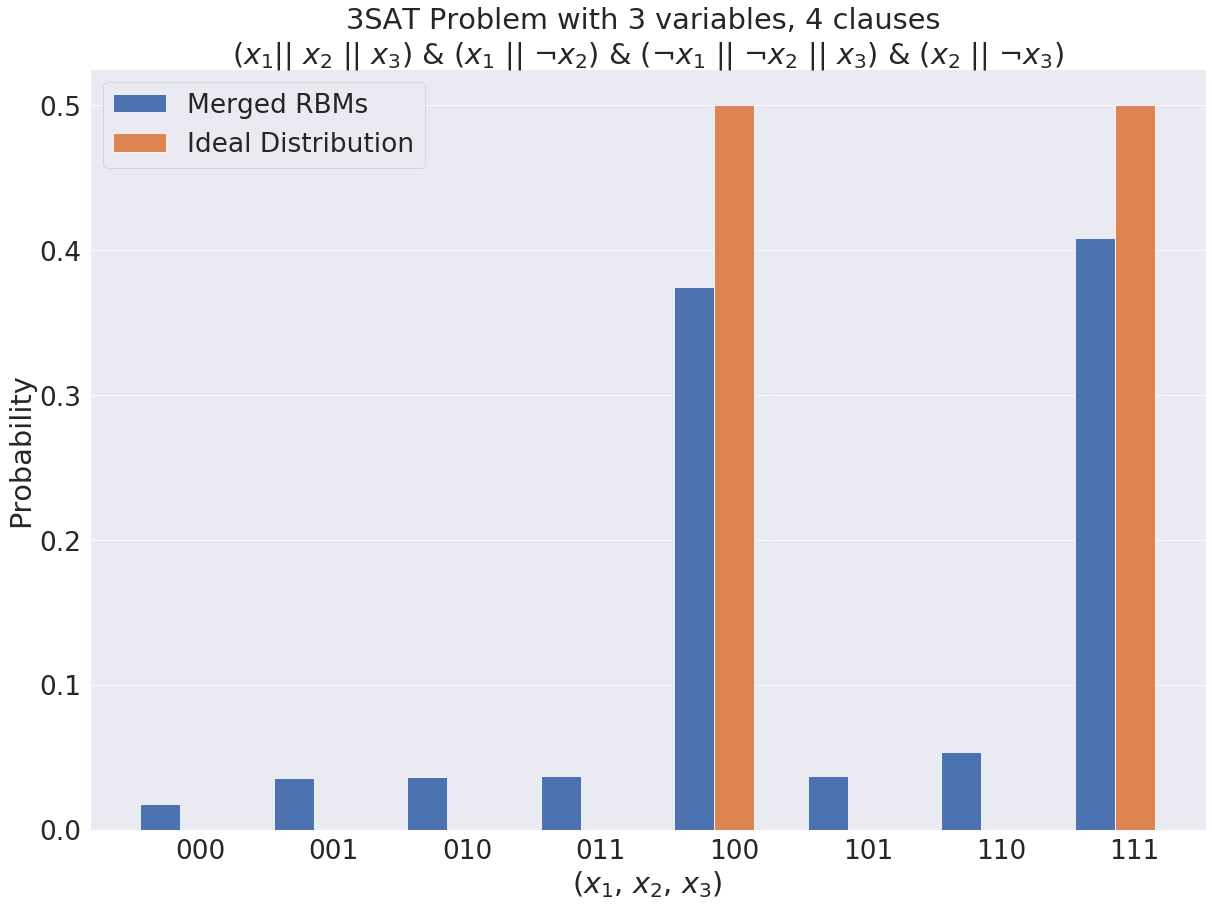

In [19]:
sat_test = SATrbm(homedir + '/SAT/benchmarks/simple_v3_c4.cnf', lambd=3)
fa_merge = RBM.load(homedir + '/LogicRBM/trained/faMerged.p')
fa = RBM.load(homedir + '/LogicRBM/trained/fullAdder.p')

width = 0.3

#######################
    
corr_probs = utils.generateDistribution(3, 2, lambda A, B, C: [A^B^C, (A&B)|(C&(A^B))])
print(corr_probs)
probs_fa = fa_merge.probs().numpy()
print(fa_merge.outbits)
coll_fa = [0] * 32
for j, val in enumerate(probs_fa):
    newKey = ''.join([format(j, '09b')[i] for i in fa_merge.outbits])
    coll_fa[int(newKey, 2)] += val
print(coll_fa)
print(len(coll_fa))

inds_fa = np.arange(len(coll_fa))
lbls_fa = lbls = [format(x, '05b') for x in range(len(coll_fa))]

inds = np.arange(len(probs_fa))

#plt.subplot(211)
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel(r'State in form ($A$, $B$, $C_{in}$, S, $C_{out}$)', labelpad=10)
ax.set_ylabel(r'Probability')
ax.set_title('Full Adder by Merging Logical Units')
ax.bar(inds_fa-width, coll_fa, tick_label=lbls_fa, width=width, label='Merged RBMs')
ax.bar(inds_fa, fa.probs().numpy(), tick_label=lbls_fa, width=width, label='Fully Trained RBM')
ax.bar(inds_fa+width, corr_probs, tick_label=lbls_fa, width=width, label='Ideal Distribution')
ax.set_xticks(inds_fa, lbls_fa)
ax.xaxis.set_tick_params(rotation=90)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.savefig('Merge_FA.pdf', bbox_inches = "tight")
plt.legend()

##########################

fig, ax = plt.subplots(figsize=(20, 14))
probs_sat = sat_test.probs().numpy()
coll_sat = [np.sum(probs_sat[i:i+8]) for i in range(0, len(probs_sat), 8)]
exact = np.zeros(8)
exact[4] = 0.5; exact[7] = 0.5
lbls = [format(x, '03b') for x in range(len(coll_sat))]
inds_sat = np.arange(len(coll_sat))


#plt.subplot(212)
ax.set_xlabel(r'($x_1$, $x_2$, $x_3$)')
ax.set_ylabel(r'Probability')
ax.set_title('3SAT Problem with 3 variables, 4 clauses \n' + 
         r'($x_1$|| $x_2$ || $x_3$) & ($x_1$ || $\neg x_2$) & ($\neg x_1$ || $\neg x_2$ || $x_3$) & ($x_2$ || $\neg x_3$)')
ax.bar(inds_sat, coll_sat, tick_label=lbls, width=width, label='Merged RBMs')
ax.bar(inds_sat+width, exact, tick_label=lbls, width=width, label='Ideal Distribution')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.legend()
    

plt.savefig('Merge_SAT.pdf', bbox_inches = "tight")
plt.show()

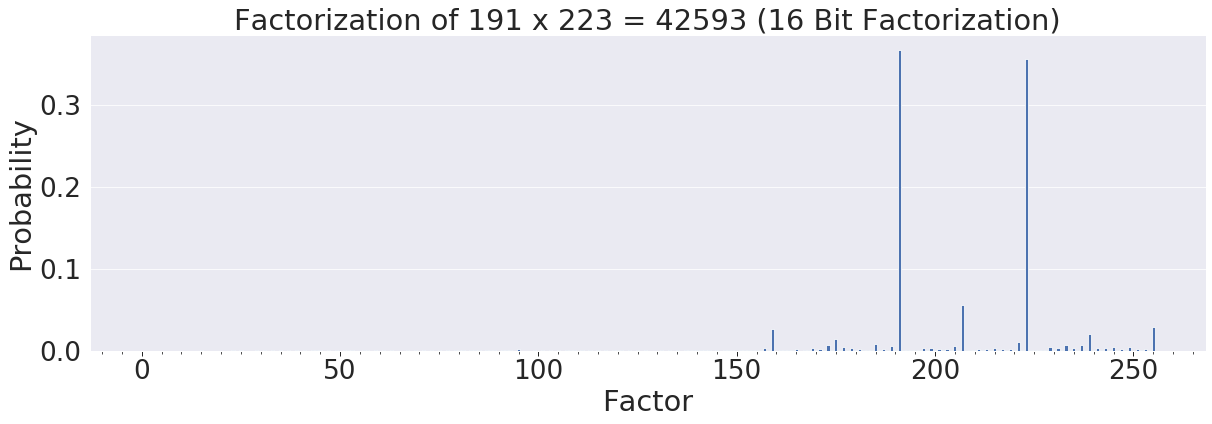

In [20]:
plt.rcParams['figure.figsize'] = (20, 6)
with open(homedir + '/LogicRBM/outputs/Mult8-long.p', 'rb') as f:
    Mult8_long = pickle.load(f)
Mult8_dict = Mult8_long['out_dict']
f1 = Mult8_long['factor1']
f2 = Mult8_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])

sns.set_style('dark', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

fact1 = np.zeros(256)
fact2 = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1[a] += val
    fact2[b] += val

plt.bar(np.arange(256), (fact1 + fact2)/(np.sum(fact1 + fact2)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
plt.xlabel('Factor')
plt.ylabel('Probability')
plt.title('Factorization of {0} x {1} = {2} (16 Bit Factorization)'.format(int(f1), int(f2), int(f1*f2)))
plt.gca().yaxis.grid(True)
plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('Factorization_16bit.pdf')

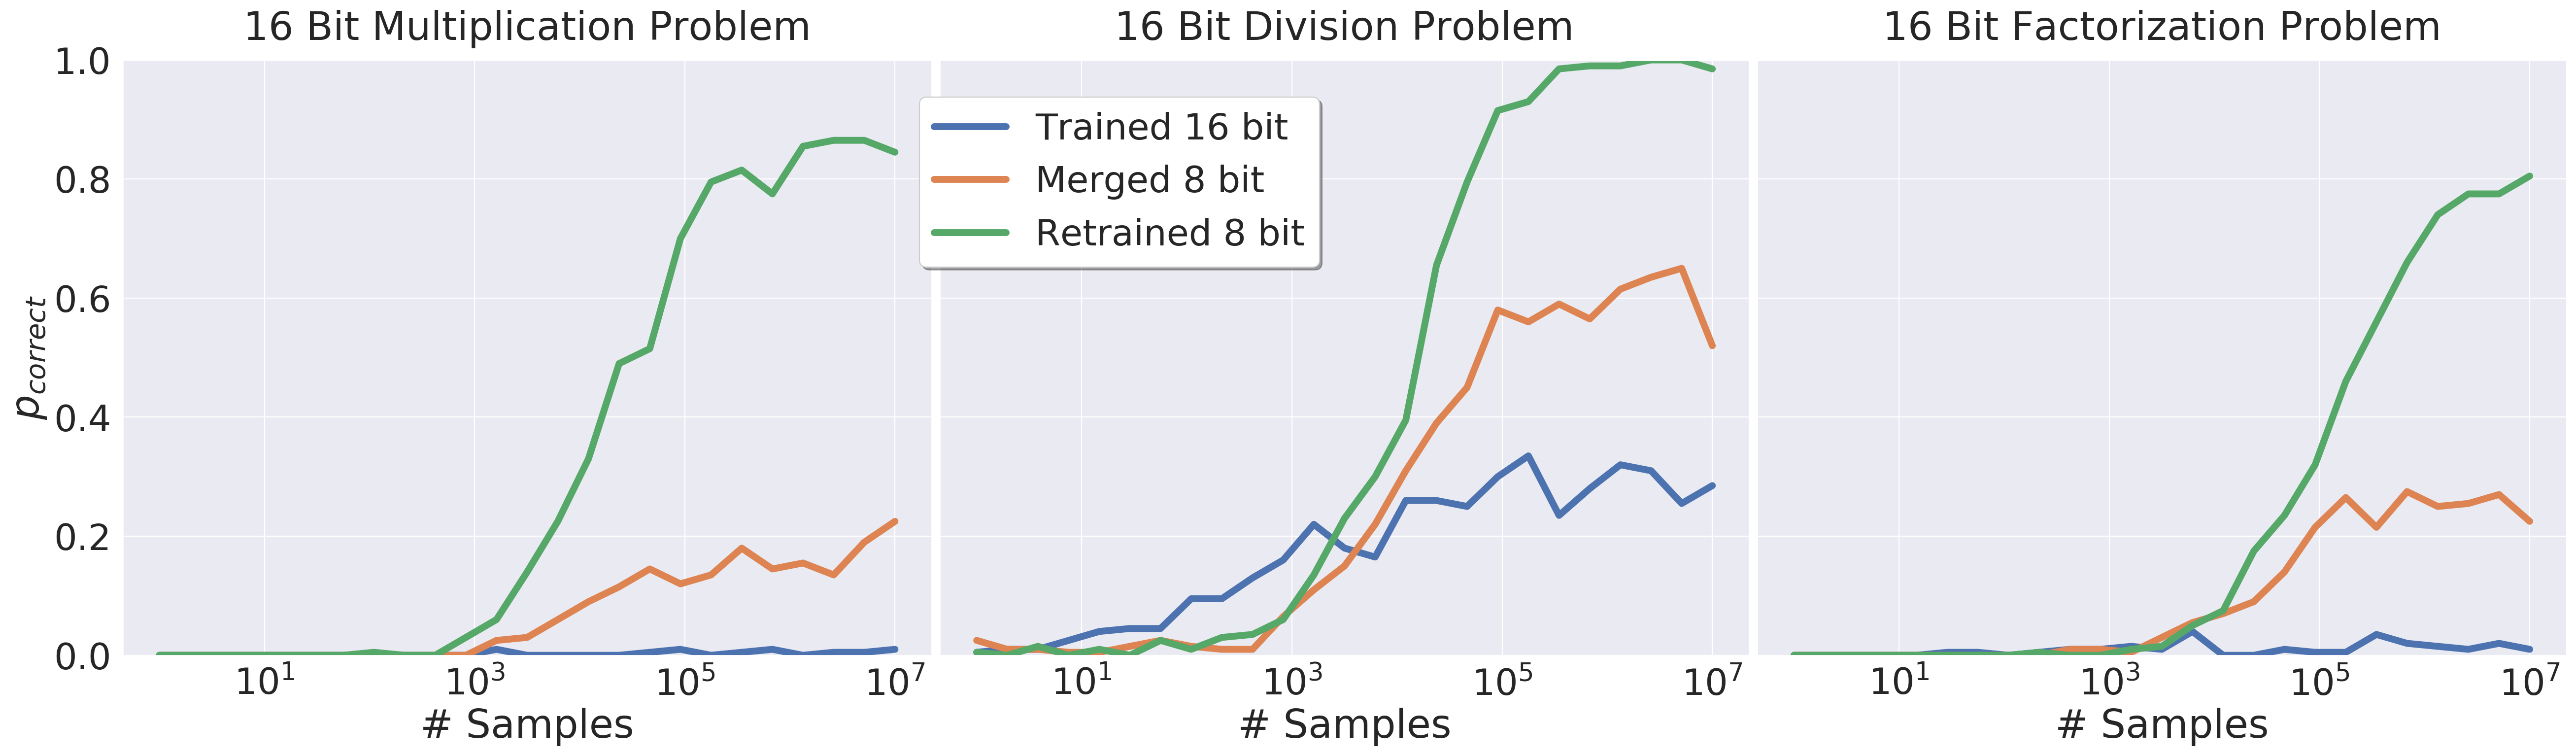

In [21]:
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8-Variability-long_200109_1.p', 'rb') as f:
    Mult8_comp_retrain = pickle.load(f)
    
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8_new_200409_0.p', 'rb') as f:
    Mult8_new = pickle.load(f)
    
sns.set_style('darkgrid')
plt.rcParams['lines.linewidth'] = 5.0
plt.rcParams['font.size'] = 28

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(32, 8), dpi=200)
f.subplots_adjust(wspace=0.01, hspace=0.6)


samps = Mult8_comp_retrain['samples']
merged = np.array(Mult8_comp_retrain['Mult8-Mult4'])
#retrained = np.array(Mult8_new['8BitMergeMult_200320_2'])
retrained = np.array(Mult8_comp_retrain['Mult8-Mult4-retrain'])
trained = np.array(Mult8_comp_retrain['Mult8'])
ax1.set_ylim(0, 1)

ax1.semilogx(samps, trained[0, :])
ax1.semilogx(samps, merged[0, :])
ax1.semilogx(samps, retrained[0, :])
#ax1.semilogx(Mult8_new['samples'], retrained[0, :])

ax1.set_title('16 Bit Multiplication Problem', y=1.02)
ax1.set_ylabel('$p_{correct}$')
ax1.set_xlabel('# Samples')

#plt.savefig('outputs/Mult8Compare_multiplication.pdf')


#plt.subplot(132)
#plt.figure()

ax2.set_ylim(0, 1)
ax2.semilogx(samps, trained[1, :])
ax2.semilogx(samps, merged[1, :])
#ax2.semilogx(Mult8_new['samples'], retrained[1, :])
ax2.semilogx(samps, retrained[1, :])

ax2.set_title('16 Bit Division Problem', y=1.02)
#ax2.set_ylabel('$p_{correct}$')
ax2.set_xlabel('# Samples')
#plt.savefig('outputs/Mult8Compare_division.pdf')

#plt.subplot(133)
#plt.figure()

ax3.set_ylim(0, 1)
ax3.semilogx(samps, trained[2, :])
ax3.semilogx(samps, merged[2, :])
ax3.semilogx(samps, retrained[2, :])
#ax3.semilogx(Mult8_new['samples'], retrained[2, :])


ax3.set_title('16 Bit Factorization Problem', y=1.02)
#ax3.set_ylabel('$p_{correct}$')
ax3.set_xlabel('# Samples')
#plt.savefig('outputs/Mult8Compare_retrain.pdf')

f.legend(labels=['Trained 16 bit', 'Merged 8 bit', 'Retrained 8 bit'], bbox_to_anchor=(0.0, 0.62, 0.71, .15), 
         loc='lower center', mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)


plt.savefig('16BitCompare.pdf',  bbox_inches = "tight")
plt.show()


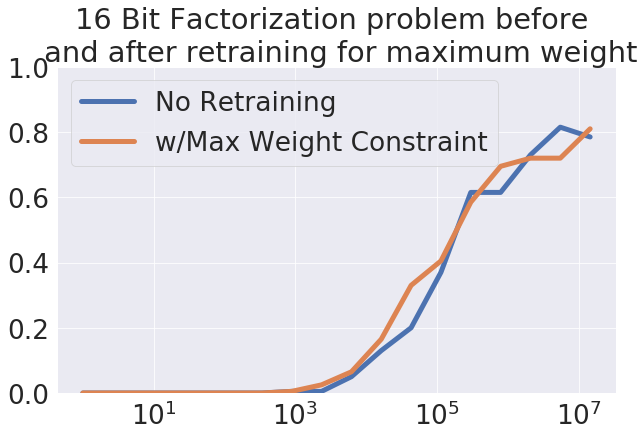

In [22]:
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8-Mult4-max4-long_200103_0.p', 'rb') as f:
    M8M4_max4 = pickle.load(f)
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8-Mult4-long_191223_0.p', 'rb') as f:
    M8M4 = pickle.load(f)
with sns.axes_style('darkgrid'):    
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(0, 1)
    ax.semilogx(M8M4['samples'][:-2], M8M4['Mult8-Mult4-retrain'][2, :][:-2], label='No Retraining')
    ax.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='w/Max Weight Constraint')
    ax.set_title('16 Bit Factorization problem before \n and after retraining for maximum weight')
    ax.legend()

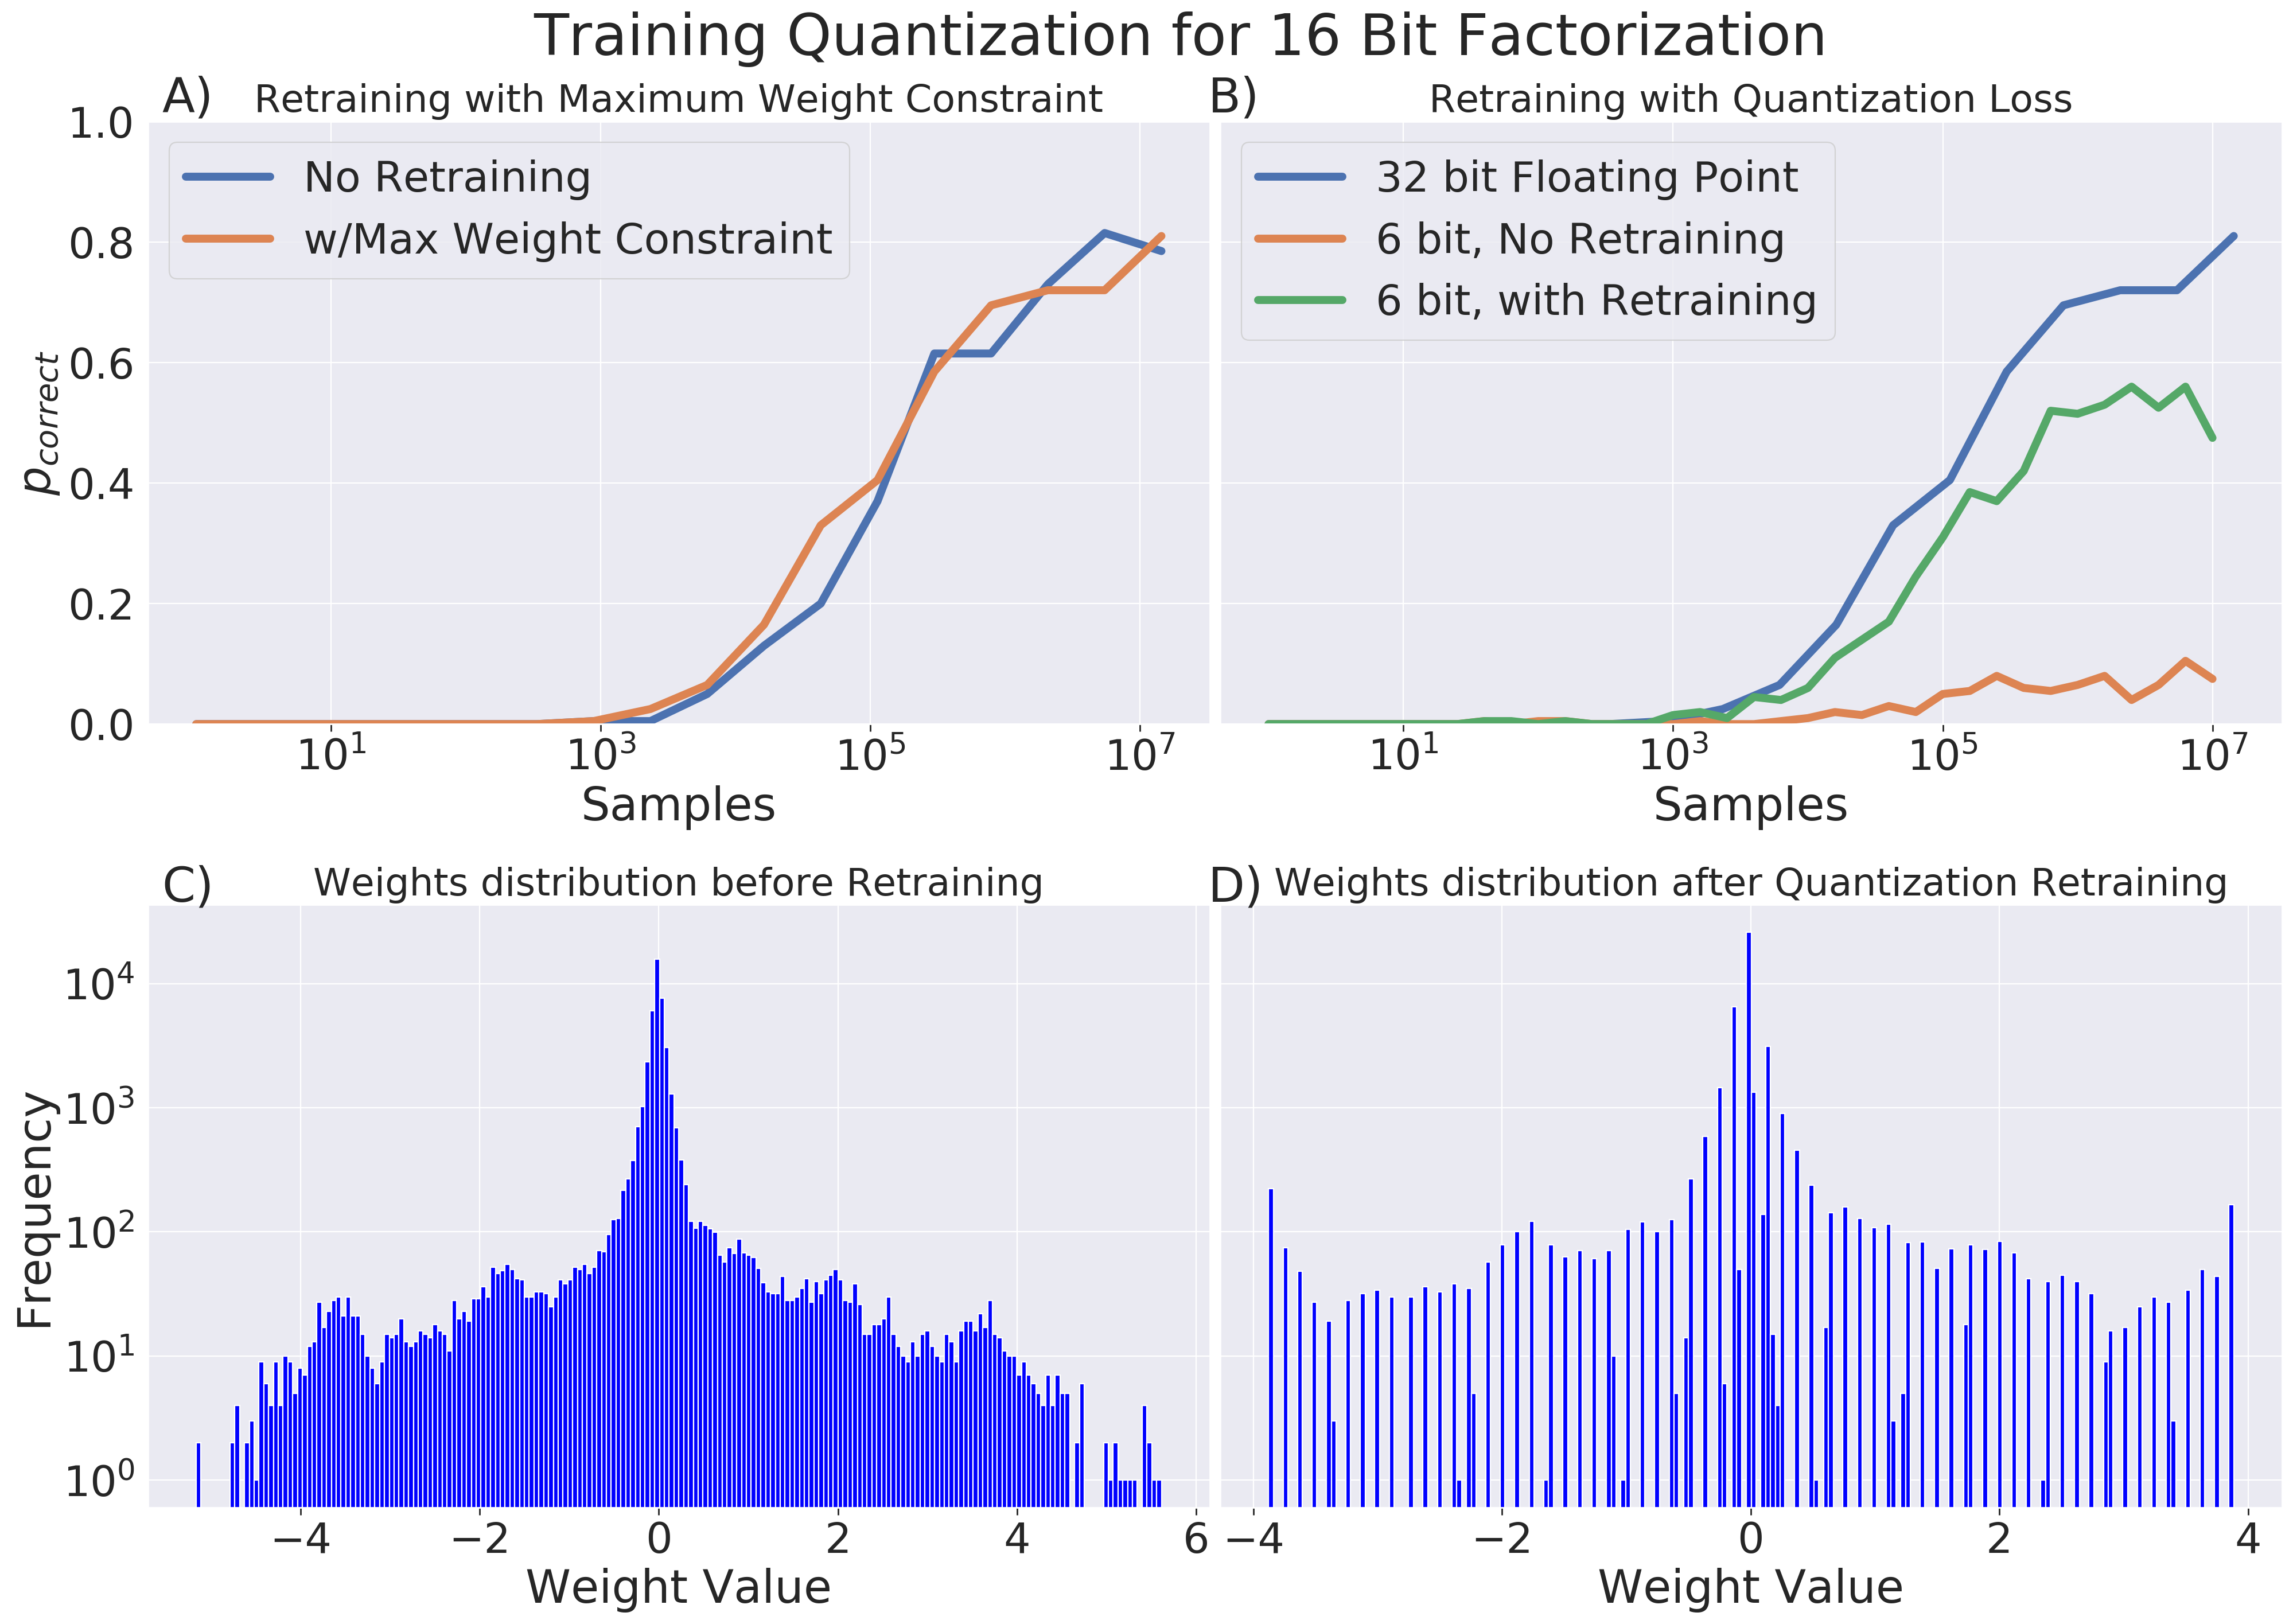

In [23]:
#M8_retrain = RBM.load(homedir + '/LogicRBM/trained/MergeMult8_7b4p_200128_0.p')
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8_quant_compare_6b3p_200129_0.p', 'rb') as f:
    quant_compare = pickle.load(f)

caption_size=30
'''
Adi's suggestions
- More white space below titles
- More white space 

'''

M8_retrain = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-max4-quant-retrain.p')
M8 = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-retrain.p')

titlesize = 24

sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})


f, ((tax1, tax2), (bax1, bax2)) = plt.subplots(2, 2, sharey='row', figsize=(24, 16), dpi=200)
f.subplots_adjust(wspace=0.01, hspace=0.3)

tax1.set_ylim(0, 1)
tax1.semilogx(M8M4['samples'][:-2], M8M4['Mult8-Mult4-retrain'][2, :][:-2], label='No Retraining')
tax1.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='w/Max Weight Constraint')
tax1.set_title('Retraining with Maximum Weight Constraint', fontsize=titlesize)
tax1.set_xlabel('Samples')
tax1.set_ylabel('$p_{correct}$')
tax1.legend()

tax2.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='32 bit Floating Point')
tax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p'][2, :], label='6 bit, No Retraining')
tax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p-retrain'][2, :], label='6 bit, with Retraining')
tax2.legend()
tax2.set_xlabel('Samples')
tax2.set_title('Retraining with Quantization Loss', fontsize=titlesize)


bax1.hist(M8.weights.numpy().flatten(), color = 'blue', bins=200, log=True)
bax1.set_xlabel('Weight Value')
bax1.set_ylabel('Frequency')
bax1.set_title('Weights distribution before Retraining', fontsize=titlesize)

bax2.hist(M8_retrain.weights.numpy().flatten(), color = 'blue', bins=200, log=True)
bax2.set_xlabel('Weight Value')
bax2.set_title('Weights distribution after Quantization Retraining', fontsize=titlesize)
f.suptitle('Training Quantization for 16 Bit Factorization', y=0.94, fontsize=36)

f.text(0.13, 0.885, 'A)', fontsize=caption_size)
f.text(0.51, 0.885, 'B)', fontsize=caption_size)
f.text(0.13, 0.455, 'C)', fontsize=caption_size)
f.text(0.51, 0.455, 'D)', fontsize=caption_size)

plt.savefig('Fig_Quantization.pdf', bbox_inches='tight')

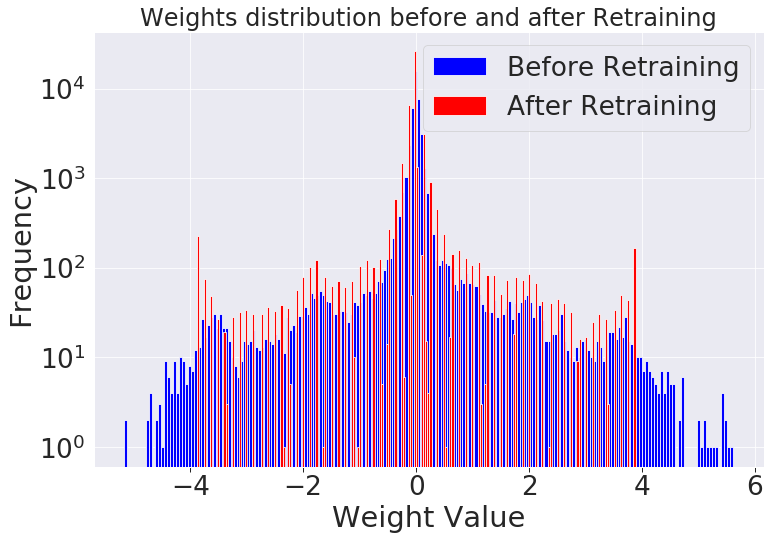

In [24]:
M8_retrain = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-max4-quant-retrain.p')
M8 = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-retrain.p')

f, ax = plt.subplots(figsize=(12, 8))

ax.hist(M8.weights.numpy().flatten(), color = 'blue', bins=200, log=True, label='Before Retraining')
ax.set_xlabel('Weight Value')
ax.set_ylabel('Frequency')
ax.set_title('Weights distribution before and after Retraining', fontsize=titlesize)

ax.hist(M8_retrain.weights.numpy().flatten(), color = 'red', bins=200, log=True, label='After Retraining')
ax.legend()
#ax.set_xlabel('Weight Value')
#bax2.set_title('Weights distribution after Quantization Retraining', fontsize=titlesize)

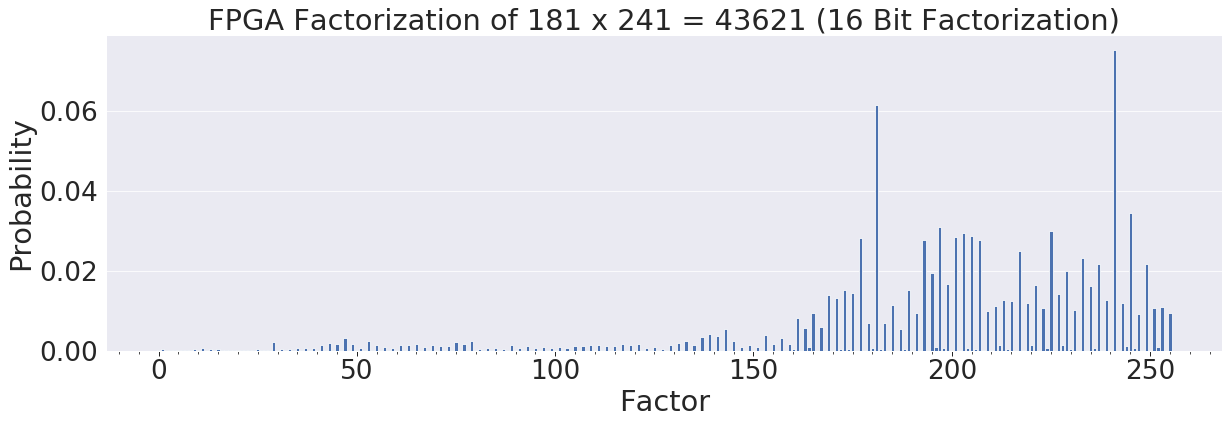

In [25]:
plt.rcParams['figure.figsize'] = (20, 6)
with open(homedir + '/../Hardware/outputs/Mult8-FPGA.p', 'rb') as f:
    Mult8_FPGA_long = pickle.load(f)
Mult8_dict = Mult8_FPGA_long['out_dict']
f1 = Mult8_FPGA_long['factor1']
f2 = Mult8_FPGA_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])

sns.set_style('dark', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

fact1 = np.zeros(256)
fact2 = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1[a] += val
    fact2[b] += val

plt.bar(np.arange(256), (fact1 + fact2)/(np.sum(fact1 + fact2)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
plt.xlabel('Factor')
plt.ylabel('Probability')
plt.title('FPGA Factorization of {0} x {1} = {2} (16 Bit Factorization)'.format(int(f1), int(f2), int(f1*f2)))
plt.gca().yaxis.grid(True)
plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('FPGA_Factorization_16bit.pdf')
plt.show()

Mult6-Mult3-max4-retrain
5BitMult_200108_8
Mult4
3BitMult_200110_1
Mult2


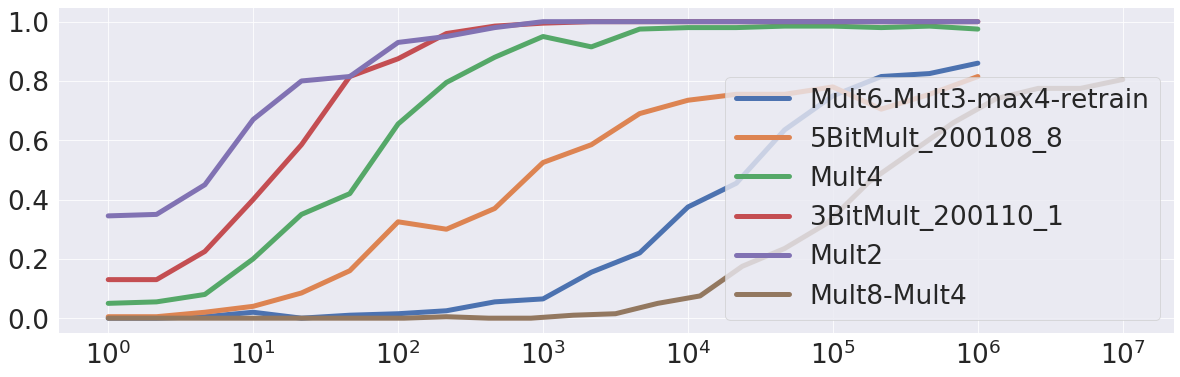

In [26]:
with open(homedir + '/LogicRBM/outputs/comparisons/Scaling_to_Mult6_200116_0.p', 'rb') as f:
    scaling = pickle.load(f)

M2 = scaling['Mult2']
M3 = scaling['3BitMult_200110_1']
M4 = scaling['Mult4']
M5 = scaling['5BitMult_200108_8']
M6 = scaling['Mult6-Mult3-max4-retrain']
M8 = retrained
    
    
sns.set_style('darkgrid')
for val in scaling:
    if not (val == 'samples' or val == 'format'):
        plt.semilogx(scaling['samples'], scaling[val][2, :], label=val)
        print(val)
plt.semilogx(Mult8_comp_retrain['samples'], retrained[2, :], label='Mult8-Mult4')
plt.legend()
plt.show()

[[1.0, 1.0, 10.0, 21.544346900318832], [1.0, 10.0, 21.544346900318832, 46.41588833612777], [10.0, 21.544346900318832, 100.0, 215.44346900318823], [46.41588833612777, 100.0, 1000.0, 10000.0], [2154.4346900318824, 10000.0, 46415.888336127726, 100000.0], [23713.737056616552, 90851.75756516881, 348070.0588428413, 1333521.432163324]]
[0.1, 0.3, 0.5, 0.7]


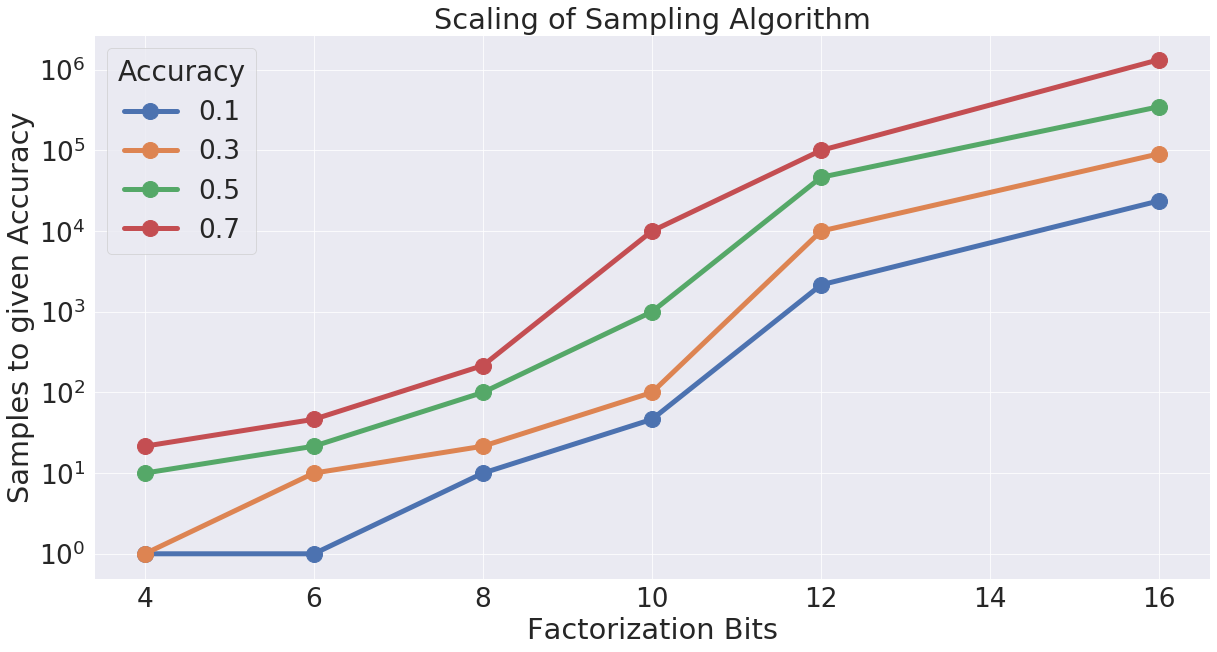

In [27]:

plt.rcParams['figure.figsize'] = (20, 10)

M2 = scaling['Mult2']
M3 = scaling['3BitMult_200110_1']
M4 = scaling['Mult4']
M5 = scaling['5BitMult_200108_8']
M6 = scaling['Mult6-Mult3-max4-retrain']
M8 = retrained
samps = scaling['samples']
scalingRBMs = [M2, M3, M4, M5, M6]

bits = np.array([4, 6, 8, 10, 12, 16])
phase_space = 2**bits
scaling_perf = []
percents = [0.1, 0.3, 0.5, 0.7]
for model in scalingRBMs:
    temparr = []
    for thresh in percents:
        temparr.append(samps[np.greater(model[2, :], thresh)][0])
    scaling_perf.append(temparr)

scalingRBMs.append(M8)
temparr = []
for thresh in percents:
    temparr.append(Mult8_comp_retrain['samples'][np.greater(M8[2, :], thresh)][0])
scaling_perf.append(temparr)
print(scaling_perf)
print(percents)
plt.semilogy(bits, scaling_perf, marker='o', markersize=16)
#plt.semilogy(bits, phase_space, linestyle='--')
#plt.legend(labels=percents + ['Phase Space'], title='Accuracy')
plt.legend(labels=percents, title='Accuracy', title_fontsize='28')
plt.title('Scaling of Sampling Algorithm')
plt.xlabel('Factorization Bits')
plt.ylabel('Samples to given Accuracy')
plt.savefig('CPUScaling.pdf')
plt.show()

In [28]:

with open(homedir + '/LogicRBM/outputs/MultTimeCompare_200204.p', 'rb') as f:
    time_compare = pickle.load(f)

with open(homedir + '/../Hardware/outputs/Mult_Compare_FPGA.p', 'rb') as f:
    FPGA_compare = pickle.load(f)
    
print(time_compare)
print(FPGA_compare)

sampT_CPU = np.flip(np.mean(time_compare['times'], axis=1)/time_compare['num_samps'])
print(sampT_CPU)

#70 Mhz
sampT_FPGA = 1/(70 * 10**6)
print(sampT_FPGA)

{'times': array([[60.2318027 , 60.57910419, 61.1099031 , 60.20729828, 61.39593244,
        61.11432528, 61.27013779, 60.38808441, 62.04747272, 61.39730167],
       [60.18745208, 61.06483293, 59.5132916 , 59.07991815, 60.28950834,
        60.95659733, 59.92164898, 59.75119472, 58.83935857, 60.36216879],
       [51.36483455, 51.9694109 , 51.14793944, 52.19152975, 51.55599809,
        49.32047701, 52.65071154, 51.8261869 , 52.19266844, 51.30863333],
       [50.39982986, 49.27066493, 49.62424183, 48.92464733, 49.36435151,
        48.3435967 , 46.84023213, 49.67490554, 51.77295494, 49.7318337 ],
       [48.47594023, 49.78123522, 50.97111726, 50.14413261, 51.57522035,
        50.34209895, 49.03968763, 50.19185424, 48.29797721, 48.51491642],
       [49.74286294, 50.40369678, 47.33339643, 48.73054981, 47.44758987,
        47.65209031, 48.39862776, 46.70843077, 48.13726354, 45.55466366]]), 'num_tests': 10, 'num_samps': 100000, 'num_bits': [8, 6, 5, 4, 3, 2]}
{'FPGA Correct': [[47, 13, 11, 0, 1,

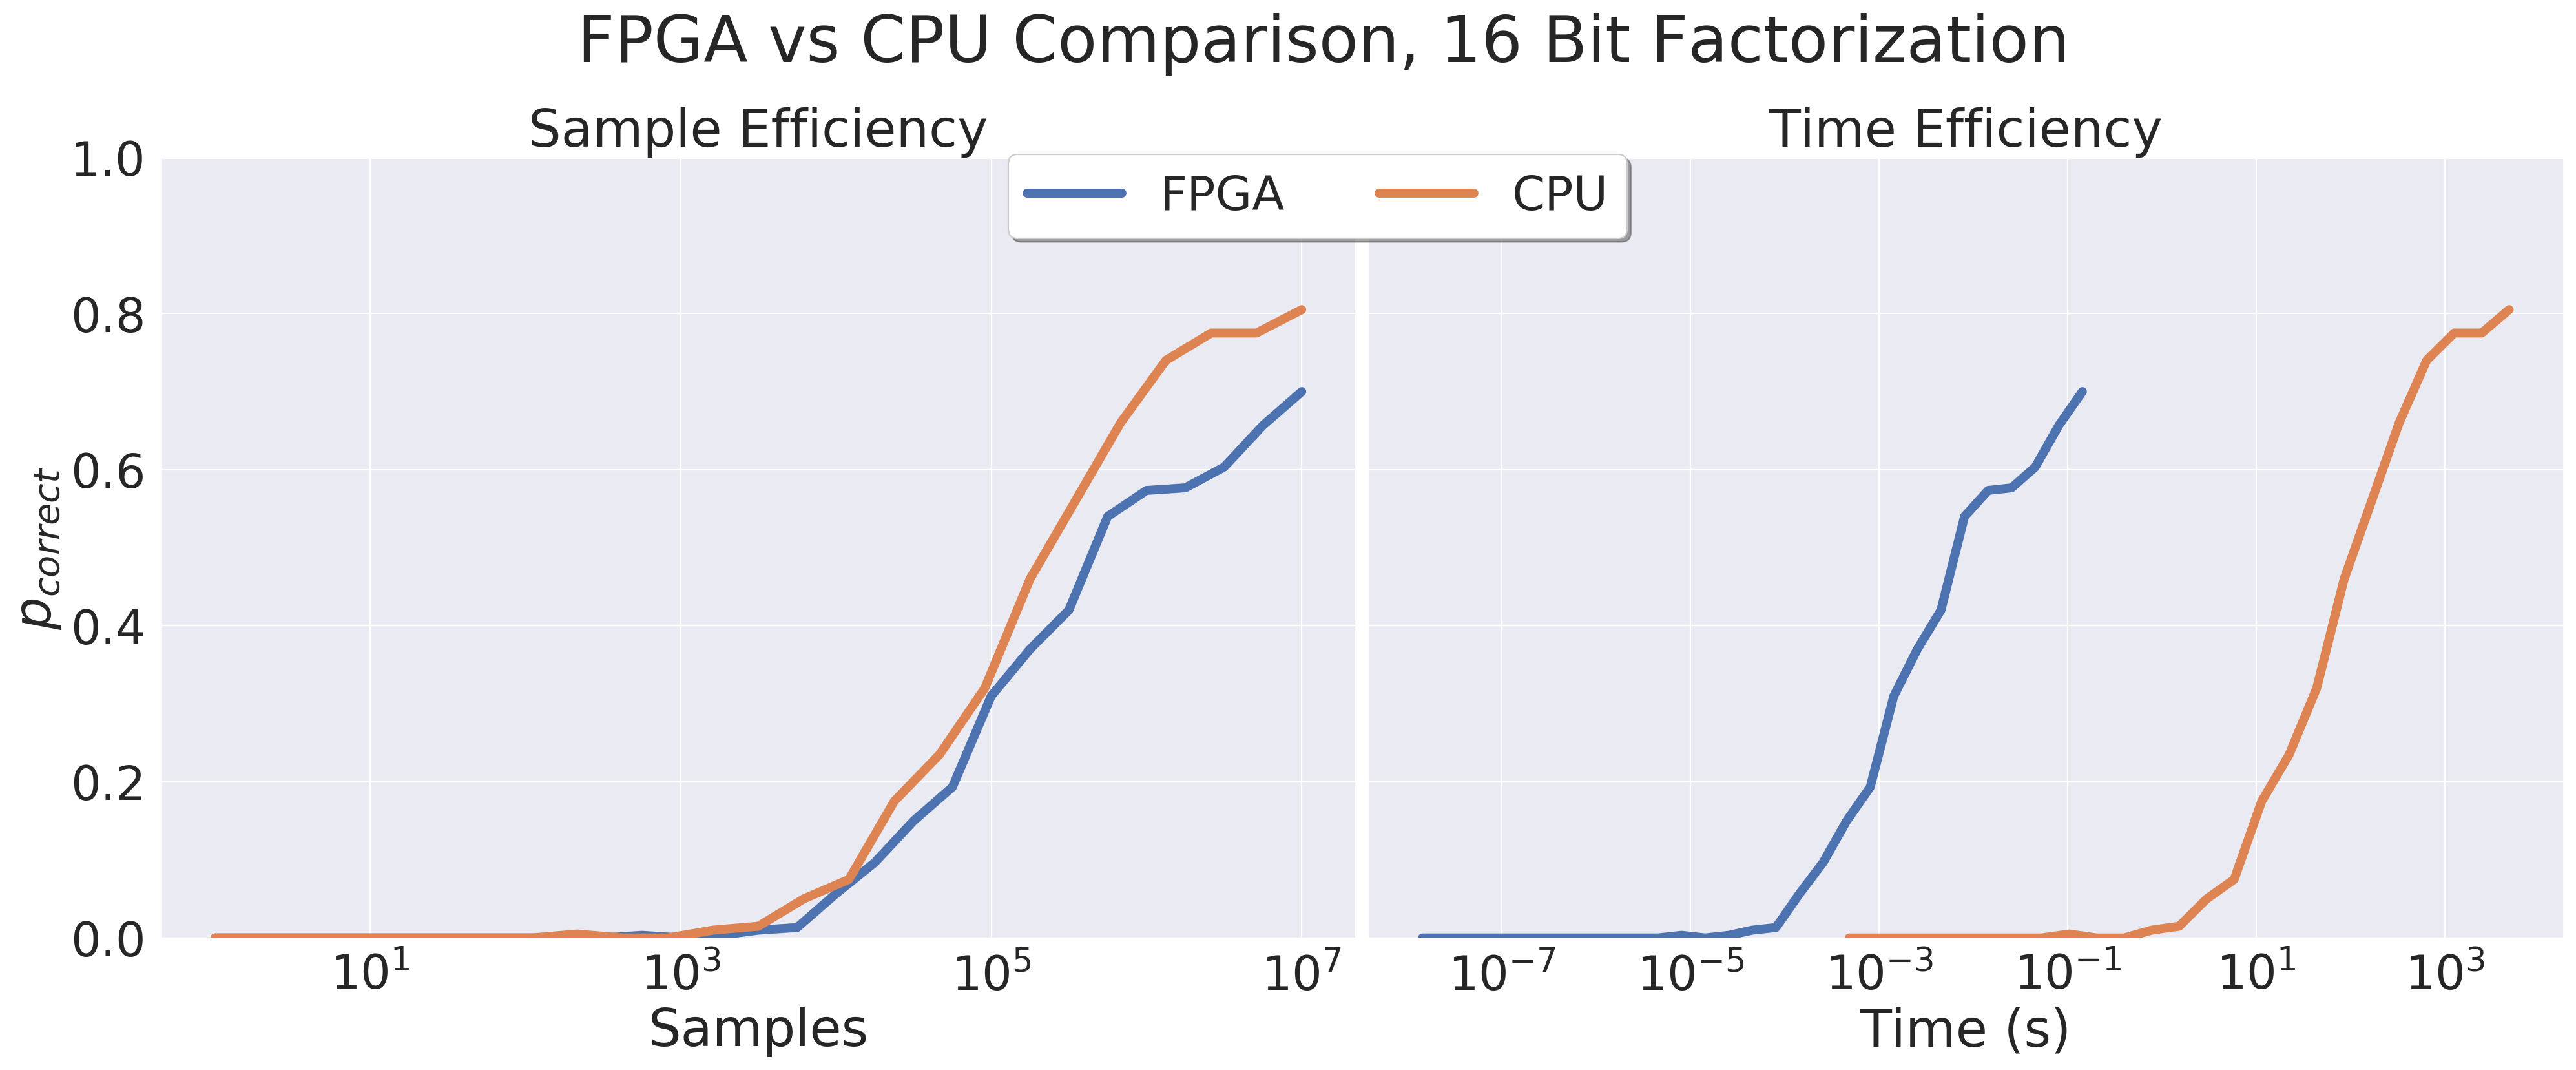

In [29]:
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

num_cases = 200

with open(homedir + '/../Hardware/outputs/FPGA_corr_200302.p', 'rb') as f:
    FPGA = pickle.load(f)

num_cases_fpga = FPGA['num cases']

f, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(24, 8), dpi=200)
f.subplots_adjust(wspace=0.01, hspace=0.6)

ax1.set_ylim(0, 1)
ax1.semilogx(FPGA['Samples'], np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax1.semilogx(Mult8_comp_retrain['samples'], retrained[2, :], label='CPU')
ax1.set_ylabel('$p_{correct}$')
ax1.set_xlabel('Samples')
ax1.set_title('Sample Efficiency')

ax2.semilogx(FPGA['Samples']*sampT_FPGA, np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax2.semilogx(Mult8_comp_retrain['samples']*sampT_CPU[0], retrained[2, :], label='CPU')
ax2.set_xlabel('Time (s)')
ax2.set_title('Time Efficiency')

f.suptitle('FPGA vs CPU Comparison, 16 Bit Factorization', fontsize=36, y=1.02)
         
#f.legend(labels=['FPGA', 'CPU'], loc='upper left', bbox_to_anchor=(0.85, 0.88),
#         mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)
handles, labels = ax2.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(0.0, 0.77, 0.85, .15), 
         loc='center', mode=None, borderaxespad=0, ncol=3, frameon=True, facecolor='white', shadow=True)
#f.legend(labels=['FPGA', 'CPU'])
#plt.savefig('timeEff_Mult8.pdf', bbox_inches = "tight")


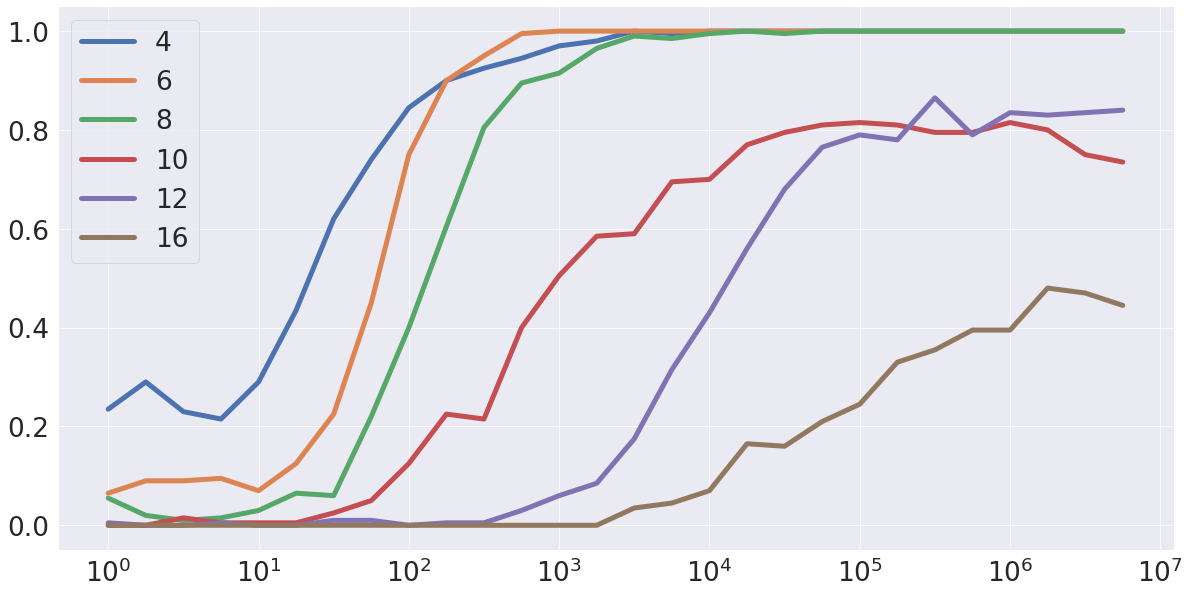

In [30]:
f = plt.figure()
plt.semilogx(FPGA_compare['samps'][:-1], np.array(FPGA_compare['FPGA Correct'])/FPGA_compare['num_cases'])
plt.legend(labels=[4, 6, 8, 10, 12, 16])

[0.235 0.29  0.23  0.215 0.29  0.435 0.62  0.74  0.845 0.9   0.925 0.945
 0.97  0.98  1.    0.995 1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
[0.065 0.09  0.09  0.095 0.07  0.125 0.225 0.45  0.75  0.9   0.95  0.995
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
[0.055 0.02  0.01  0.015 0.03  0.065 0.06  0.22  0.4   0.605 0.805 0.895
 0.915 0.965 0.99  0.985 0.995 1.    0.995 1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
[0.    0.    0.015 0.005 0.005 0.005 0.025 0.05  0.125 0.225 0.215 0.4
 0.505 0.585 0.59  0.695 0.7   0.77  0.795 0.81  0.815 0.81  0.795 0.795
 0.815 0.8   0.75  0.735]
[0.005 0.    0.    0.005 0.    0.    0.01  0.01  0.    0.005 0.005 0.03
 0.06  0.085 0.175 0.315 0.43  0.56  0.68  0.765 0.79  0.78  0.865 0.79
 0.835 0.83  0.835 0.84 ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 4, 17, 29, 45, 58, 93, 111, 126, 162, 172, 173, 181, 197, 210]
[False False False False False False False F

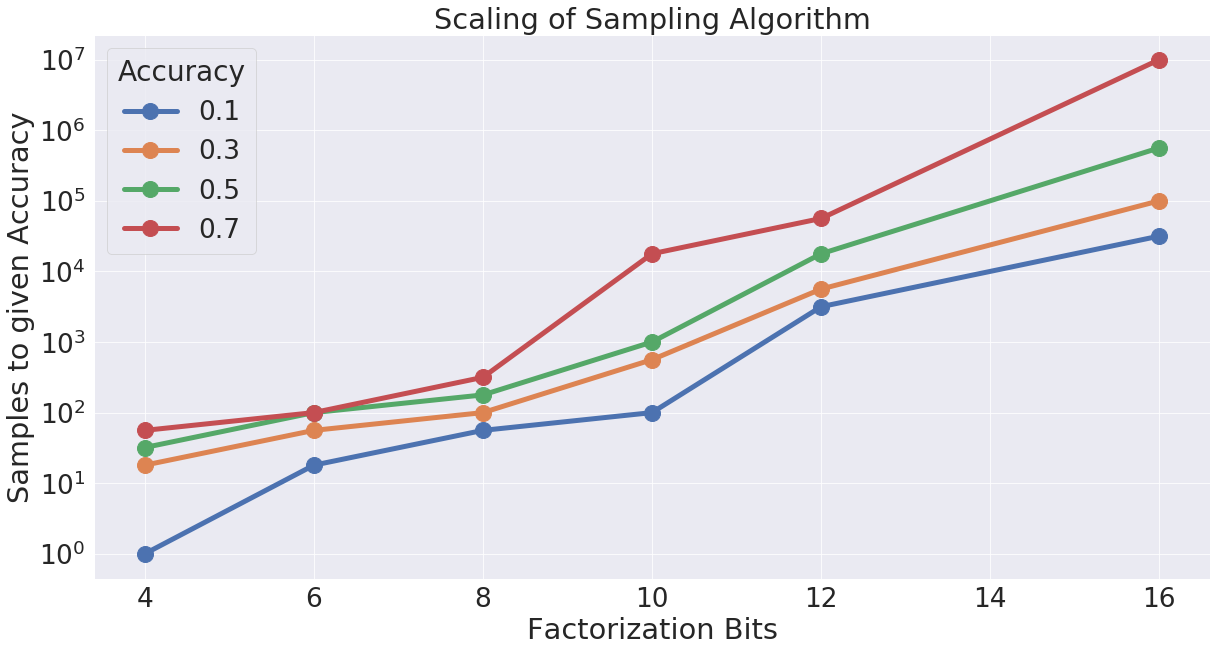

In [31]:
bits = np.array([4, 6, 8, 10, 12, 16])

FPGAscaling_perf = []
percents = [0.1, 0.3, 0.5, 0.7]
FPGA_samps = np.round(FPGA_compare['samps'][:-1])
FPGA_perf = np.transpose(FPGA_compare['FPGA Correct'])[:-1]/FPGA_compare['num_cases']
for model in FPGA_perf:
    print(model)
    temparr = []
    for thresh in percents:
        temparr.append(FPGA_samps[np.greater(model, thresh)][0])
    FPGAscaling_perf.append(temparr)

    
M8_FPGA = np.array(FPGA['FPGA Correct'])/num_cases_fpga
print(FPGA['FPGA Correct'])

temparr = []
for thresh in percents:
    print(np.greater(M8_FPGA, thresh))
    temparr.append(np.array(FPGA['Samples'])[np.greater_equal(M8_FPGA, thresh)][0])
#temparr.append(FPGA['Samples'][-1])
FPGAscaling_perf.append(temparr)


print(FPGAscaling_perf)
print(percents)
plt.semilogy(bits, FPGAscaling_perf, marker='o', markersize=16)
#plt.semilogy(bits, phase_space, linestyle='--')
#plt.legend(labels=percents + ['Phase Space'], title='Accuracy')
plt.legend(labels=percents, title='Accuracy', title_fontsize='28')
plt.title('Scaling of Sampling Algorithm')
plt.xlabel('Factorization Bits')
plt.ylabel('Samples to given Accuracy')
plt.savefig('FPGAScaling.pdf')
plt.show()

No handles with labels found to put in legend.


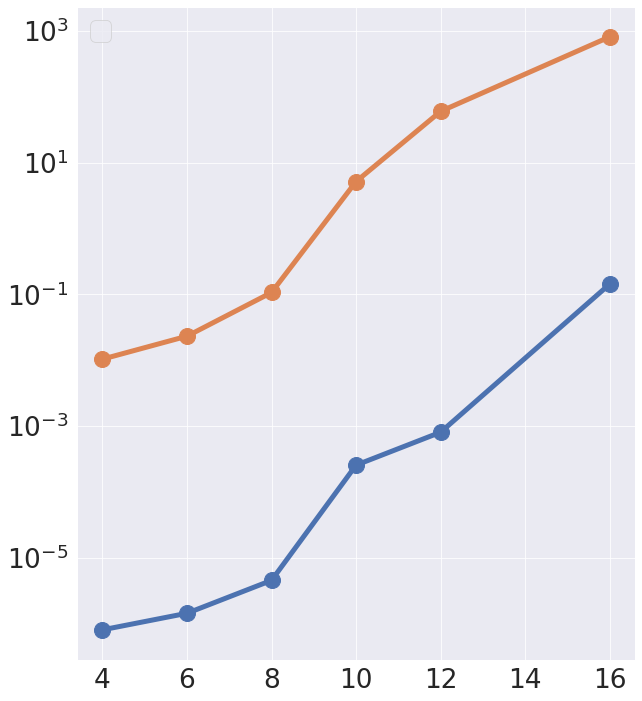

In [32]:
FPGAscaling_time = np.array(FPGAscaling_perf) * sampT_FPGA
CPUscaling_time = np.array([np.array(scaling_perf[i])*sampT_CPU[i] for i in range(len(bits))])

plt.figure(figsize=(10, 12))
plt.semilogy(bits, FPGAscaling_time[:, -1], marker='o', markersize=16)
plt.semilogy(bits, CPUscaling_time[:, -1], marker='o', markersize=16)
plt.legend()

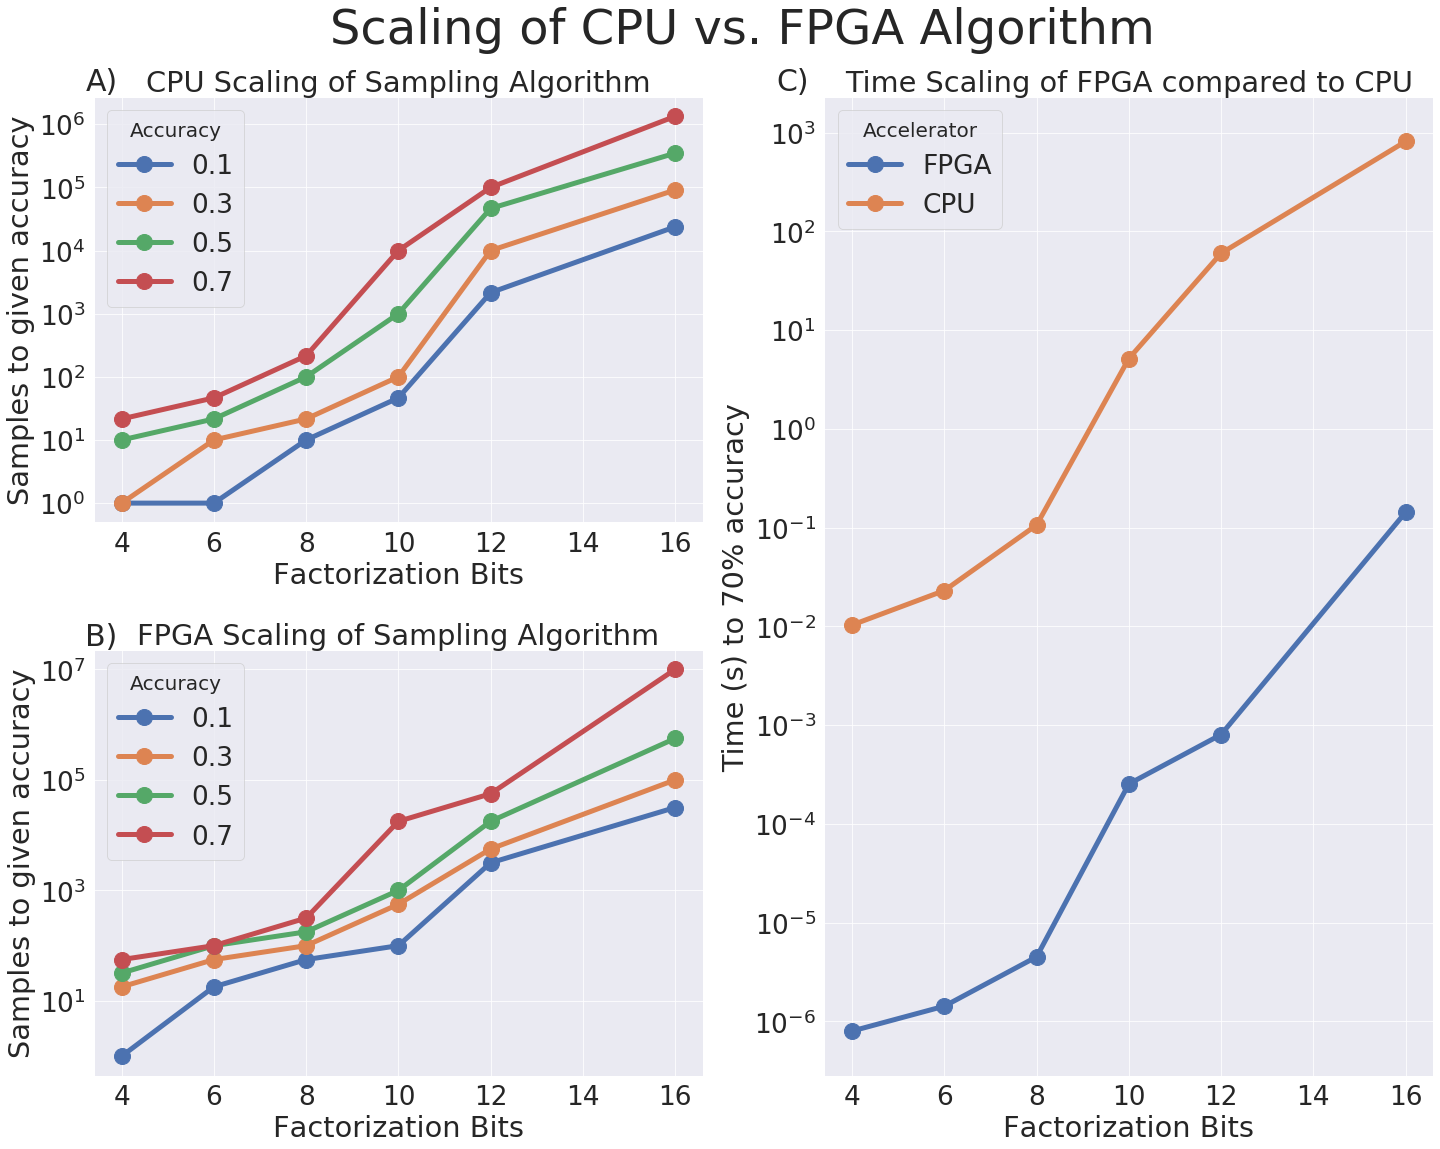

In [33]:
f = plt.figure(figsize=(24, 18))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3, figure=f)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[1, 0], sharex=ax1)
ax3 = plt.subplot(grid[:, 1])

ax1.semilogy(bits, scaling_perf, marker='o', markersize=16)
#plt.semilogy(bits, phase_space, linestyle='--')
#plt.legend(labels=percents + ['Phase Space'], title='Accuracy')
ax1.legend(labels=percents, title='Accuracy', title_fontsize='20')
ax1.set_title('CPU Scaling of Sampling Algorithm')
ax1.set_xlabel('Factorization Bits')
ax1.set_ylabel('Samples to given accuracy')


ax2.semilogy(bits, FPGAscaling_perf, marker='o', markersize=16)
ax2.legend(labels=percents, title='Accuracy', title_fontsize='20')
ax2.set_title('FPGA Scaling of Sampling Algorithm')
ax2.set_xlabel('Factorization Bits')
ax2.set_ylabel('Samples to given accuracy')

ax3.semilogy(bits, FPGAscaling_time[:, -1], marker='o', markersize=16, label='FPGA')
ax3.semilogy(bits, CPUscaling_time[:, -1], marker='o', markersize=16, label='CPU')
ax3.set_title('Time Scaling of FPGA compared to CPU')
ax3.legend(title='Accelerator', title_fontsize='20')
ax3.set_xlabel('Factorization Bits')
ax3.set_ylabel('Time (s) to 70% accuracy')
ax3.set_yticks(np.logspace(-6, 3, 10))

f.suptitle('Scaling of CPU vs. FPGA Algorithm', fontsize=48, y=0.95)

f.text(0.12, 0.885, 'A)', fontsize=caption_size)
f.text(0.52, 0.885, 'C)', fontsize=caption_size)
f.text(0.12, 0.457, 'B)', fontsize=caption_size)

plt.savefig('Fig_Scaling.pdf', bbox_inches = "tight")
plt.show()


In [34]:
np.logspace(-7, 3, 11)

array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03])

In [35]:
plt.rcParams['figure.figsize'] = (20, 6)
with open(homedir + '/../Hardware/outputs/Mult8-FPGA.p', 'rb') as f:
    Mult8_long = pickle.load(f)
Mult8_dict = Mult8_long['out_dict']
f1 = Mult8_long['factor1']
f2 = Mult8_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])


fact1 = np.zeros(256)
fact2 = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1[a] += val
    fact2[b] += val

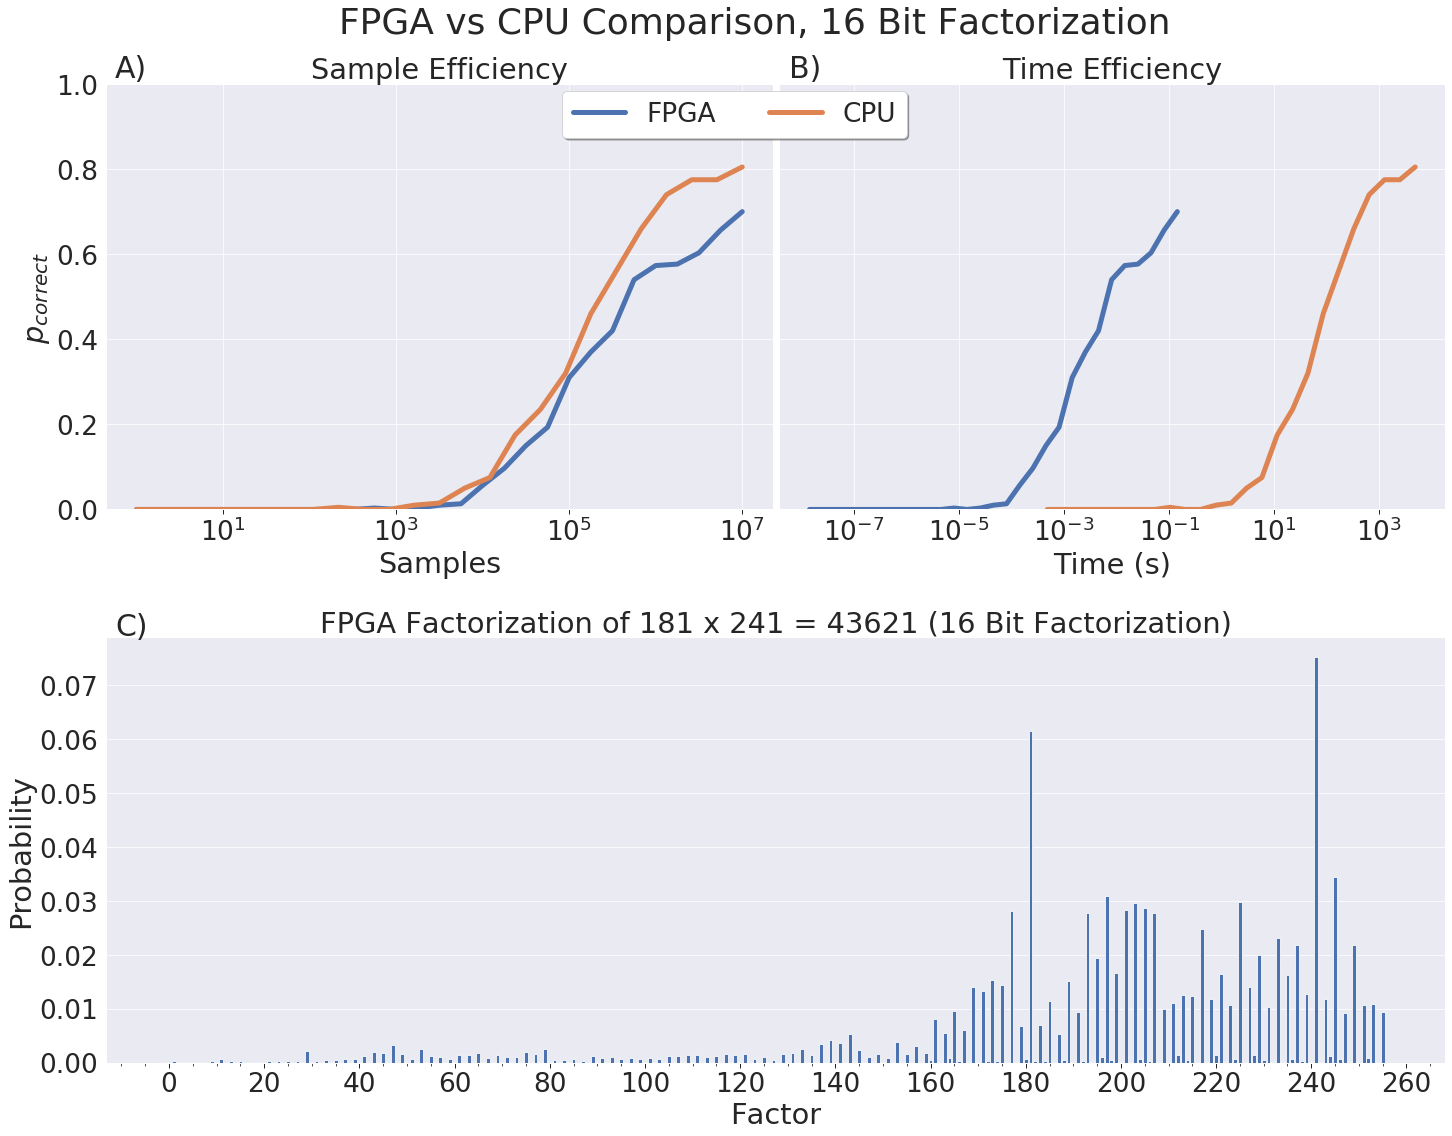

In [36]:
plt.rcParams['font.size'] = 16
caption_size = 30
sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

f = plt.figure(figsize=(24, 18))
grid = plt.GridSpec(2, 2, wspace=0.01, hspace=0.3, figure=f)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, :])


num_cases = 200

with open(homedir + '/../Hardware/outputs/FPGA_corr_200302.p', 'rb') as file:
    FPGA = pickle.load(file)

num_cases_fpga = FPGA['num cases']
    
ax1.set_ylim(0, 1)
ax1.semilogx(FPGA['Samples'], np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax1.semilogx(Mult8_comp_retrain['samples'], retrained[2, :], label='CPU')
ax1.set_ylabel('$p_{correct}$')
ax1.set_xlabel('Samples')
ax1.set_title('Sample Efficiency')

ax2.set_ylim(0, 1)
ax2.semilogx(FPGA['Samples']*sampT_FPGA, np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax2.semilogx(Mult8_comp_retrain['samples']*sampT_CPU[0], retrained[2, :], label='CPU')
ax2.set_xlabel('Time (s)')
ax2.set_title('Time Efficiency')

ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])


f.suptitle('FPGA vs CPU Comparison, 16 Bit Factorization', fontsize=36, y=0.94)
         
#f.legend(labels=['FPGA', 'CPU'], loc='upper left', bbox_to_anchor=(0.85, 0.88),
#         mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)
handles, labels = ax2.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(0.0, 0.77, 0.85, 0.15), 
         loc='lower center', mode=None, borderaxespad=0, ncol=3, frameon=True, facecolor='white', shadow=True)
#f.legend(labels=['FPGA', 'CPU'])

ax3.bar(np.arange(256), (fact1 + fact2)/(np.sum(fact1 + fact2)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
ax3.set_xlabel('Factor')
ax3.set_ylabel('Probability')
ax3.set_title('FPGA Factorization of {0} x {1} = {2} (16 Bit Factorization)'.format(int(f1), int(f2), int(f1*f2)))
ax3.yaxis.grid(True)
ax3.xaxis.grid(False)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.xaxis.set_major_locator(MultipleLocator(20))
f.text(0.13, 0.885, 'A)', fontsize=caption_size)
f.text(0.52, 0.885, 'B)', fontsize=caption_size)
f.text(0.13, 0.455, 'C)', fontsize=caption_size)

plt.savefig('Fig_FPGA16Bit.pdf', bbox_inches='tight')
plt.show()

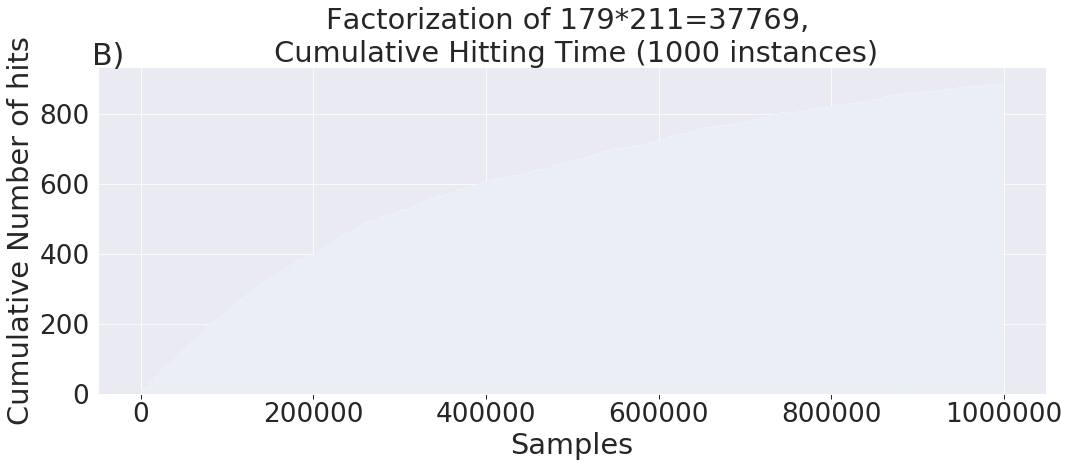

In [37]:
with open(homedir + '/LogicRBM/outputs/hitFact_raw.p', 'rb') as f:
    time_series = pickle.load(f)
with open(homedir + '/LogicRBM/outputs/hitTimes(2).p', 'rb') as f:
    hit_times = pickle.load(f)

    
#f, ((tax1, tax2), (bax1, bax2)) = plt.subplots(2, 2, figsize=(24, 16), dpi=200)
f, ax = plt.subplots(figsize= (17, 6))
ax.hist(hit_times['Hits'], density=False, cumulative=True, bins=1000)
ax.set_xlabel('Samples')
ax.set_ylabel('Cumulative Number of hits')
ax.set_title('Factorization of {0}*{1}={2}, \n Cumulative Hitting Time (1000 instances)'.format(hit_times['factor1'], 
                                    hit_times['factor2'], hit_times['factor1']*hit_times['factor2']))
f.text(0.12, 0.887, 'B)', fontsize=caption_size)
plt.savefig('CumHit.pdf', bbox_inches='tight')
plt.show()

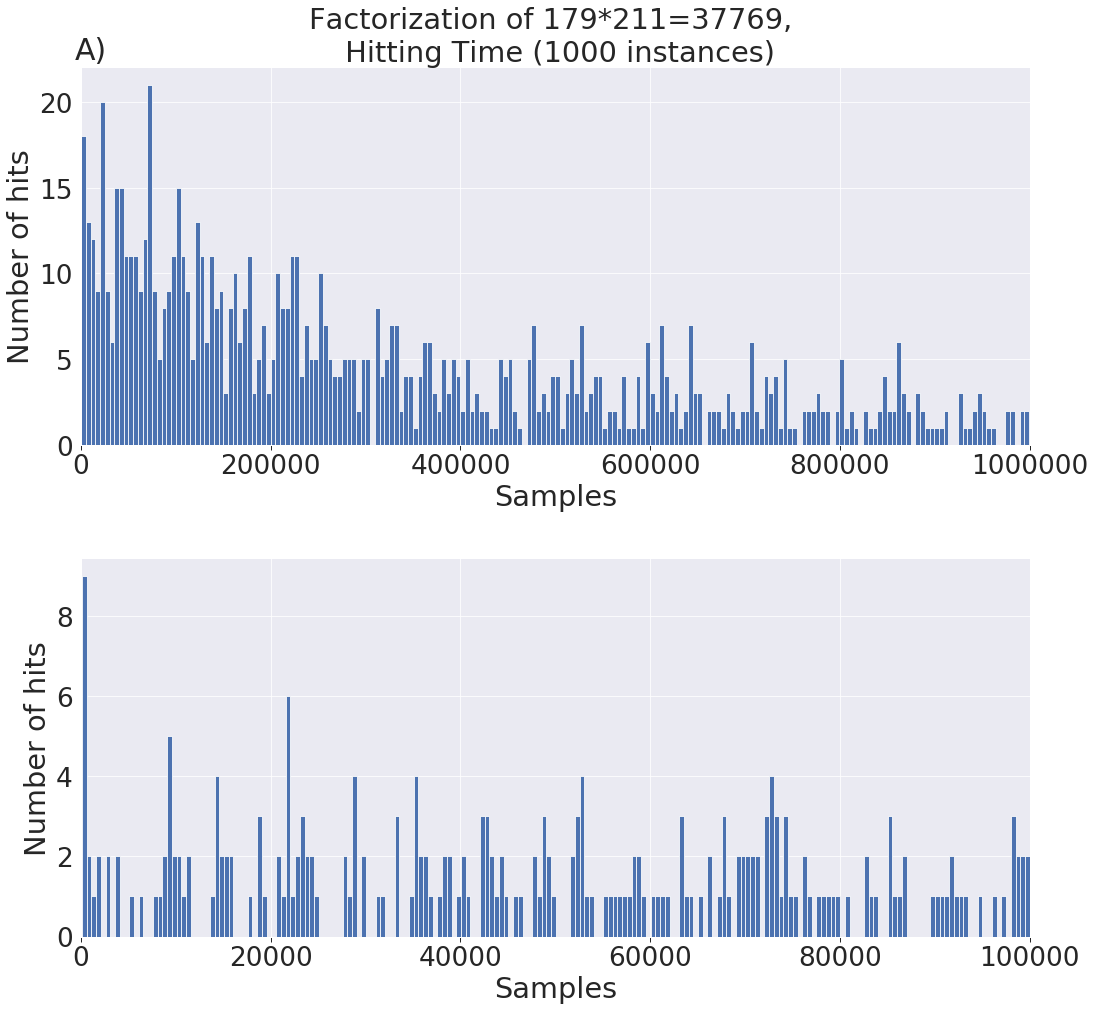

In [38]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize= (17, 16))
f.subplots_adjust(wspace=0.02, hspace=0.3)
ax1.hist(hit_times['Hits'], density=False, cumulative=False, bins=200)
ax1.set_xlabel('Samples')
ax1.set_xlim([0, 1000000])
ax1.set_ylabel('Number of hits')
ax1.set_title('Factorization of {0}*{1}={2}, \n Hitting Time (1000 instances)'.format(hit_times['factor1'], 
                                    hit_times['factor2'], hit_times['factor1']*hit_times['factor2']))

ax2.hist(hit_times['Hits'], density=False, cumulative=False, bins=2000)
ax2.set_xlabel('Samples')
ax2.set_xlim([0, 100000])
ax2.set_ylabel('Number of hits')
f.text(0.12, 0.887, 'A)', fontsize=caption_size)
plt.savefig('HitTime.pdf', bbox_inches='tight')
plt.show()

In [39]:
ind = 8
out1 = torch.Tensor(np.transpose(time_series['Chain']))
print(out1.shape)
print(out1[:, :8].shape)
tf1 = utils.listToInt(torch.transpose(out1[:, :8], 0, 1))
tf2 = utils.listToInt(torch.transpose(out1[:, 8:16], 0, 1))
ans = int(utils.listToInt(out1[0, 16:]))
print(ans)
factor1 = [0]*256
factor2 = [0]*256


# first_hit = 10**9
# argmax_hit = 10**9

# for i in range(len(tf1)):
#     factor1[int(tf1[i])] += 1
#     factor2[int(tf2[i])] += 1
#     if(np.abs(tf1[i]*tf2[i] - ans) < 0.001):
#         first_hit = min(i, first_hit)
#     if(i%1000 == 0 and np.argmax(factor1)*np.argmax(factor2) == ans):
#         argmax_hit = min(i, argmax_hit)
# print(first_hit)
# print(argmax_hit)

torch.Size([1000000, 32])
torch.Size([1000000, 8])
37769


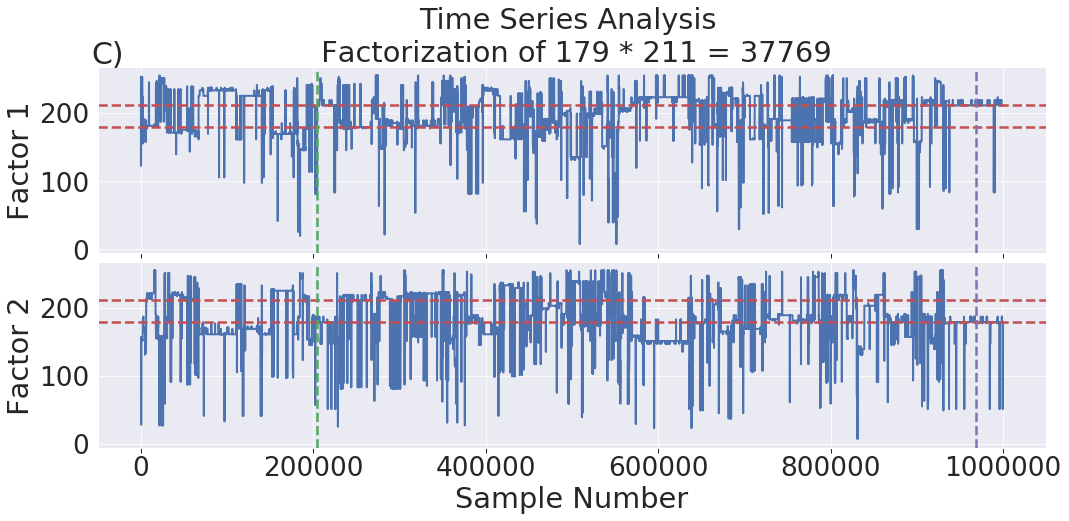

In [40]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize= (17, 7))
f.subplots_adjust(wspace=0.01, hspace=0.05)


first_hit = 204590
argmax_hit = 968800

vhwidth = 2.5
linewidth = 2

ax1.plot(tf1.numpy(), linewidth=linewidth)
ax1.set_ylabel('Factor 1')
ax1.axhline(y=time_series['factor1'], linestyle='--', color='r', linewidth=vhwidth)
ax1.axhline(y=time_series['factor2'], linestyle='--', color='r', linewidth=vhwidth)
ax1.axvline(x=first_hit, linestyle='--', color='g', linewidth=vhwidth)
ax1.axvline(x=argmax_hit, linestyle='--', color='m', linewidth=vhwidth)
ax1.set_title('Time Series Analysis \n Factorization of {0} * {1} = {2}'.format(
                time_series['factor1'], time_series['factor2'], time_series['factor1']*time_series['factor2']))

ax2.plot(tf2.numpy(), linewidth=linewidth)
ax2.set_ylabel('Factor 2')
ax2.set_xlabel('Sample Number')
ax2.axhline(y=time_series['factor1'], linestyle='--', color='r', linewidth=vhwidth)
ax2.axhline(y=time_series['factor2'], linestyle='--', color='r', linewidth=vhwidth)
ax2.axvline(x=first_hit, linestyle='--', color='g', linewidth=vhwidth)
ax2.axvline(x=argmax_hit, linestyle='--', color='m', linewidth=vhwidth)

f.text(0.12, 0.887, 'C)', fontsize=caption_size)
plt.savefig('TimeSeries.pdf', bbox_inches = "tight")
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:3115: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd2, dy / dd2
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:3115: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd2, dy / dd2
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:3115: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd2, dy / dd2


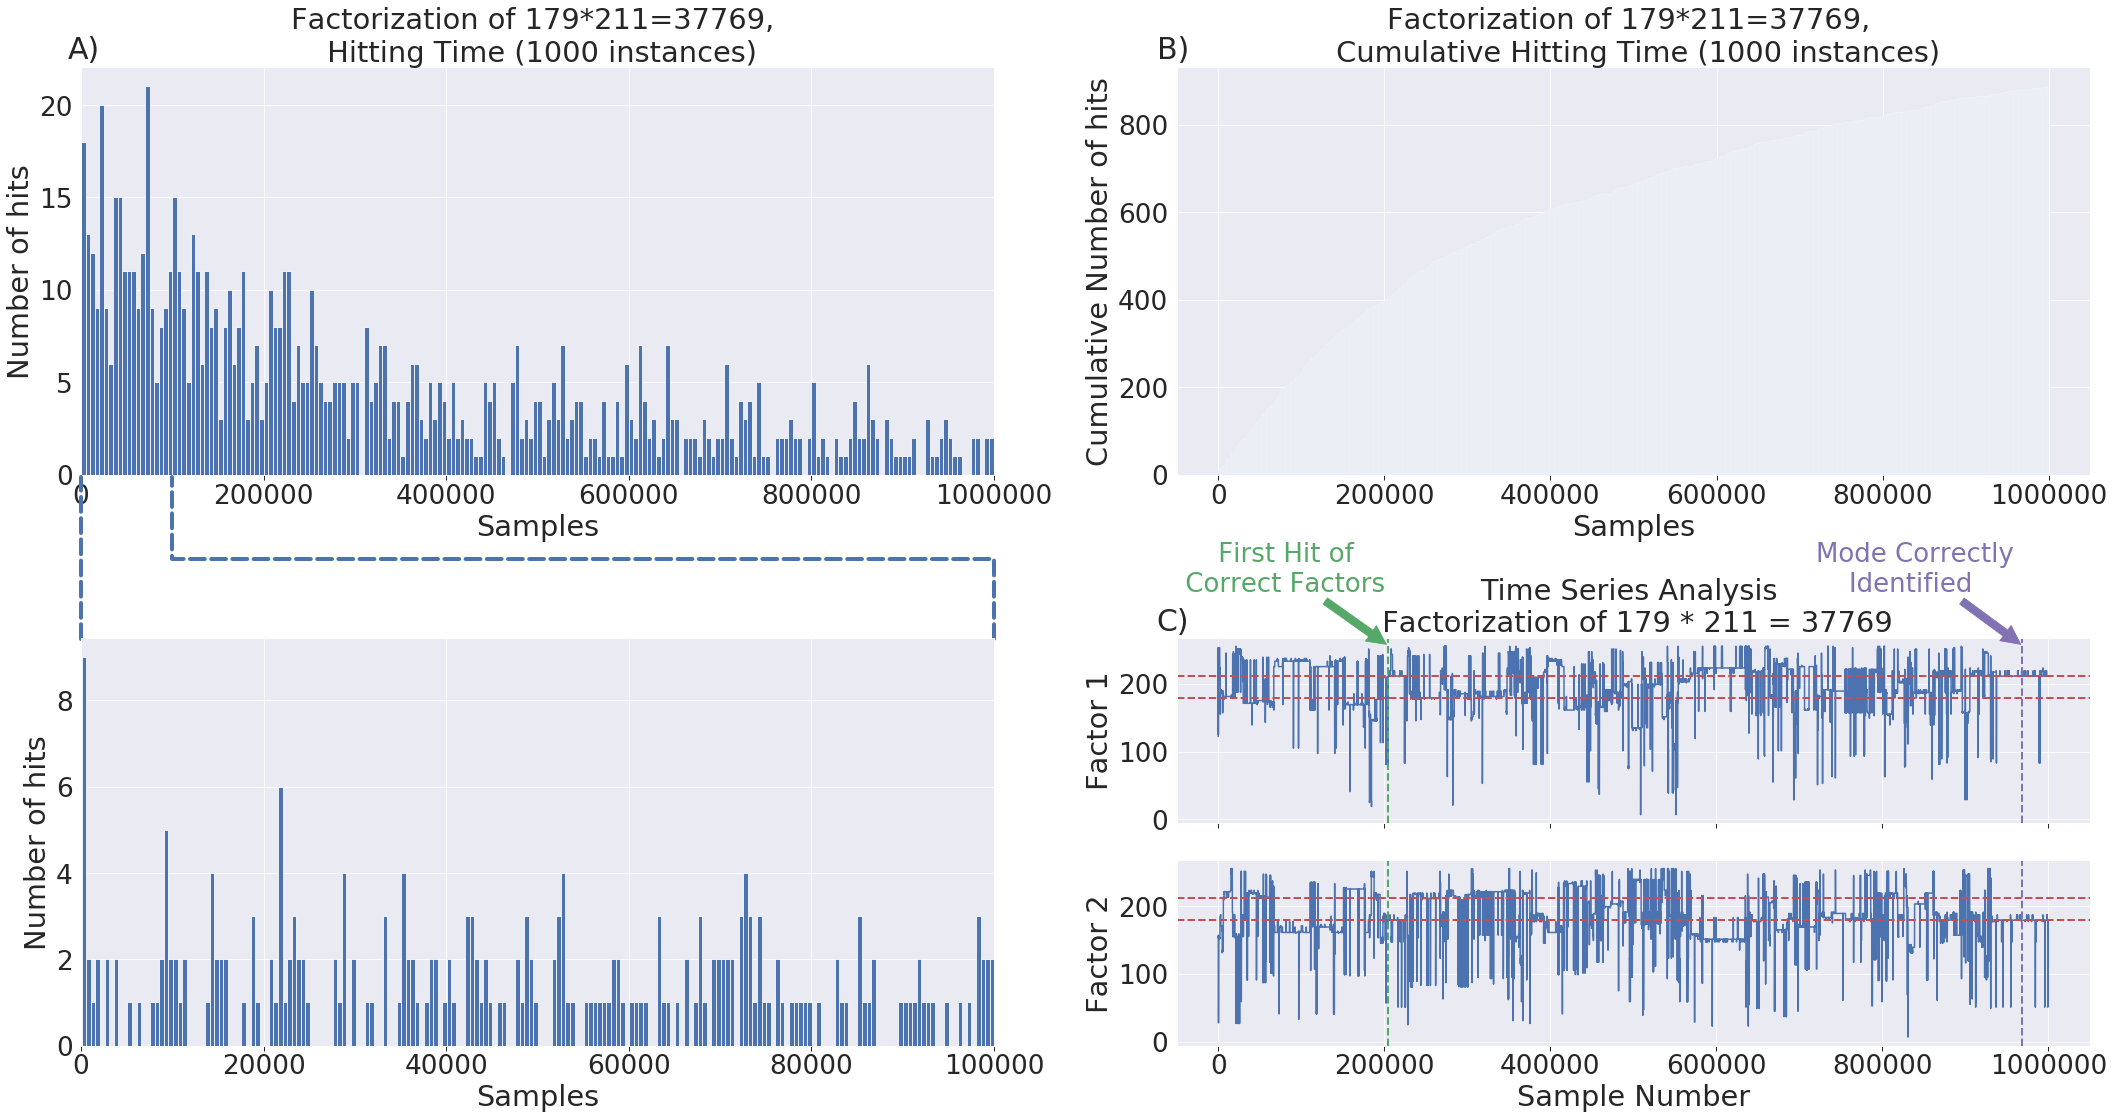

In [41]:
caption_size = 30
annot_size = 26
f = plt.figure(figsize=(36, 18))
gs = plt.GridSpec(2, 2, figure=f, wspace=0.2, hspace=0.4)
gs0 = gs[1, 1].subgridspec(2, 1, hspace=0.2)
tax1 = f.add_subplot(gs[0, 0])
tax2 = f.add_subplot(gs[1, 0])
bax1 = f.add_subplot(gs[0, 1])

tax1.hist(hit_times['Hits'], density=False, cumulative=False, bins=200)
tax1.set_xlabel('Samples')
tax1.set_xlim([0, 1000000])
tax1.set_ylabel('Number of hits')
tax1.set_title('Factorization of {0}*{1}={2}, \n Hitting Time (1000 instances)'.format(hit_times['factor1'], 
                                    hit_times['factor2'], hit_times['factor1']*hit_times['factor2']))

tax2.hist(hit_times['Hits'], density=False, cumulative=False, bins=2000)
tax2.set_xlabel('Samples')
tax2.set_xlim([0, 100000])
tax2.set_ylabel('Number of hits')
f.text(0.12, 0.887, 'A)', fontsize=caption_size)


arrwidth = 4

tax1.annotate("", xy=(100000, 0), 
                xytext=(1000000, -9), fontsize=annot_size, color='b',
                arrowprops=dict(arrowstyle='-', mutation_scale=100, linewidth=arrwidth, linestyle='--',
                                connectionstyle='bar,angle=180,fraction=-0.1', color='b'))

tax1.annotate("", xy=(0, 0), 
                xytext=(0, -9), fontsize=annot_size, color='b',
                arrowprops=dict(arrowstyle='-', mutation_scale=100, linewidth=arrwidth, linestyle='--',
                                connectionstyle='bar,angle=180,fraction=-0.1', color='b'))



bax1.hist(hit_times['Hits'], density=False, cumulative=True, bins=1000)
bax1.set_xlabel('Samples')
bax1.set_ylabel('Cumulative Number of hits')
bax1.set_title('Factorization of {0}*{1}={2}, \n Cumulative Hitting Time (1000 instances)'.format(hit_times['factor1'], 
                                    hit_times['factor2'], hit_times['factor1']*hit_times['factor2']))
f.text(0.54, 0.887, 'B)', fontsize=caption_size)

subax1 = f.add_subplot(gs0[0])
subax2 = f.add_subplot(gs0[1])

first_hit = 204590
argmax_hit = 968800

vhwidth = 2
linewidth = 1.5

subax1.plot(tf1.numpy(), linewidth=linewidth)
subax1.set_ylabel('Factor 1')
subax1.axhline(y=time_series['factor1'], linestyle='--', color='r', linewidth=vhwidth)
subax1.axhline(y=time_series['factor2'], linestyle='--', color='r', linewidth=vhwidth)
subax1.axvline(x=first_hit, linestyle='--', color='g', linewidth=vhwidth)
subax1.axvline(x=argmax_hit, linestyle='--', color='m', linewidth=vhwidth)
subax1.set_title('Time Series Analysis \n Factorization of {0} * {1} = {2}'.format(
                time_series['factor1'], time_series['factor2'], time_series['factor1']*time_series['factor2']))

subax2.plot(tf2.numpy(), linewidth=linewidth)
subax2.set_ylabel('Factor 2')
subax2.set_xlabel('Sample Number')
subax2.axhline(y=time_series['factor1'], linestyle='--', color='r', linewidth=vhwidth)
subax2.axhline(y=time_series['factor2'], linestyle='--', color='r', linewidth=vhwidth)
subax2.axvline(x=first_hit, linestyle='--', color='g', linewidth=vhwidth)
subax2.axvline(x=argmax_hit, linestyle='--', color='m', linewidth=vhwidth)

subax1.get_shared_x_axes().join(subax1, subax2)
subax1.set_xticklabels([])


subax1.annotate("     First Hit of \n Correct Factors", xy=(first_hit, 256), 
                xytext=(0, 1.25), textcoords='axes fraction', fontsize=annot_size,
                arrowprops=dict(arrowstyle='simple', mutation_scale=38, color='g'), color='g')

subax1.annotate("Mode Correctly \n    Identified", xy=(argmax_hit, 256), 
                xytext=(0.7, 1.25), textcoords='axes fraction', fontsize=annot_size,
                arrowprops=dict(arrowstyle='simple', mutation_scale=38, color='m'), color='m')


f.text(0.54, 0.445, 'C)', fontsize=caption_size)



plt.savefig('Fig_Hit.pdf', bbox_inches='tight')
plt.show()


In [42]:
plt.rcParams['figure.figsize'] = (20, 6)
with open(homedir + '/../Hardware/outputs/Mult8-FPGA.p', 'rb') as f:
    Mult8_long = pickle.load(f)
Mult8_dict = Mult8_long['out_dict']
f1 = Mult8_long['factor1']
f2 = Mult8_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])


fact1 = np.zeros(256)
fact2 = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1[a] += val
    fact2[b] += val

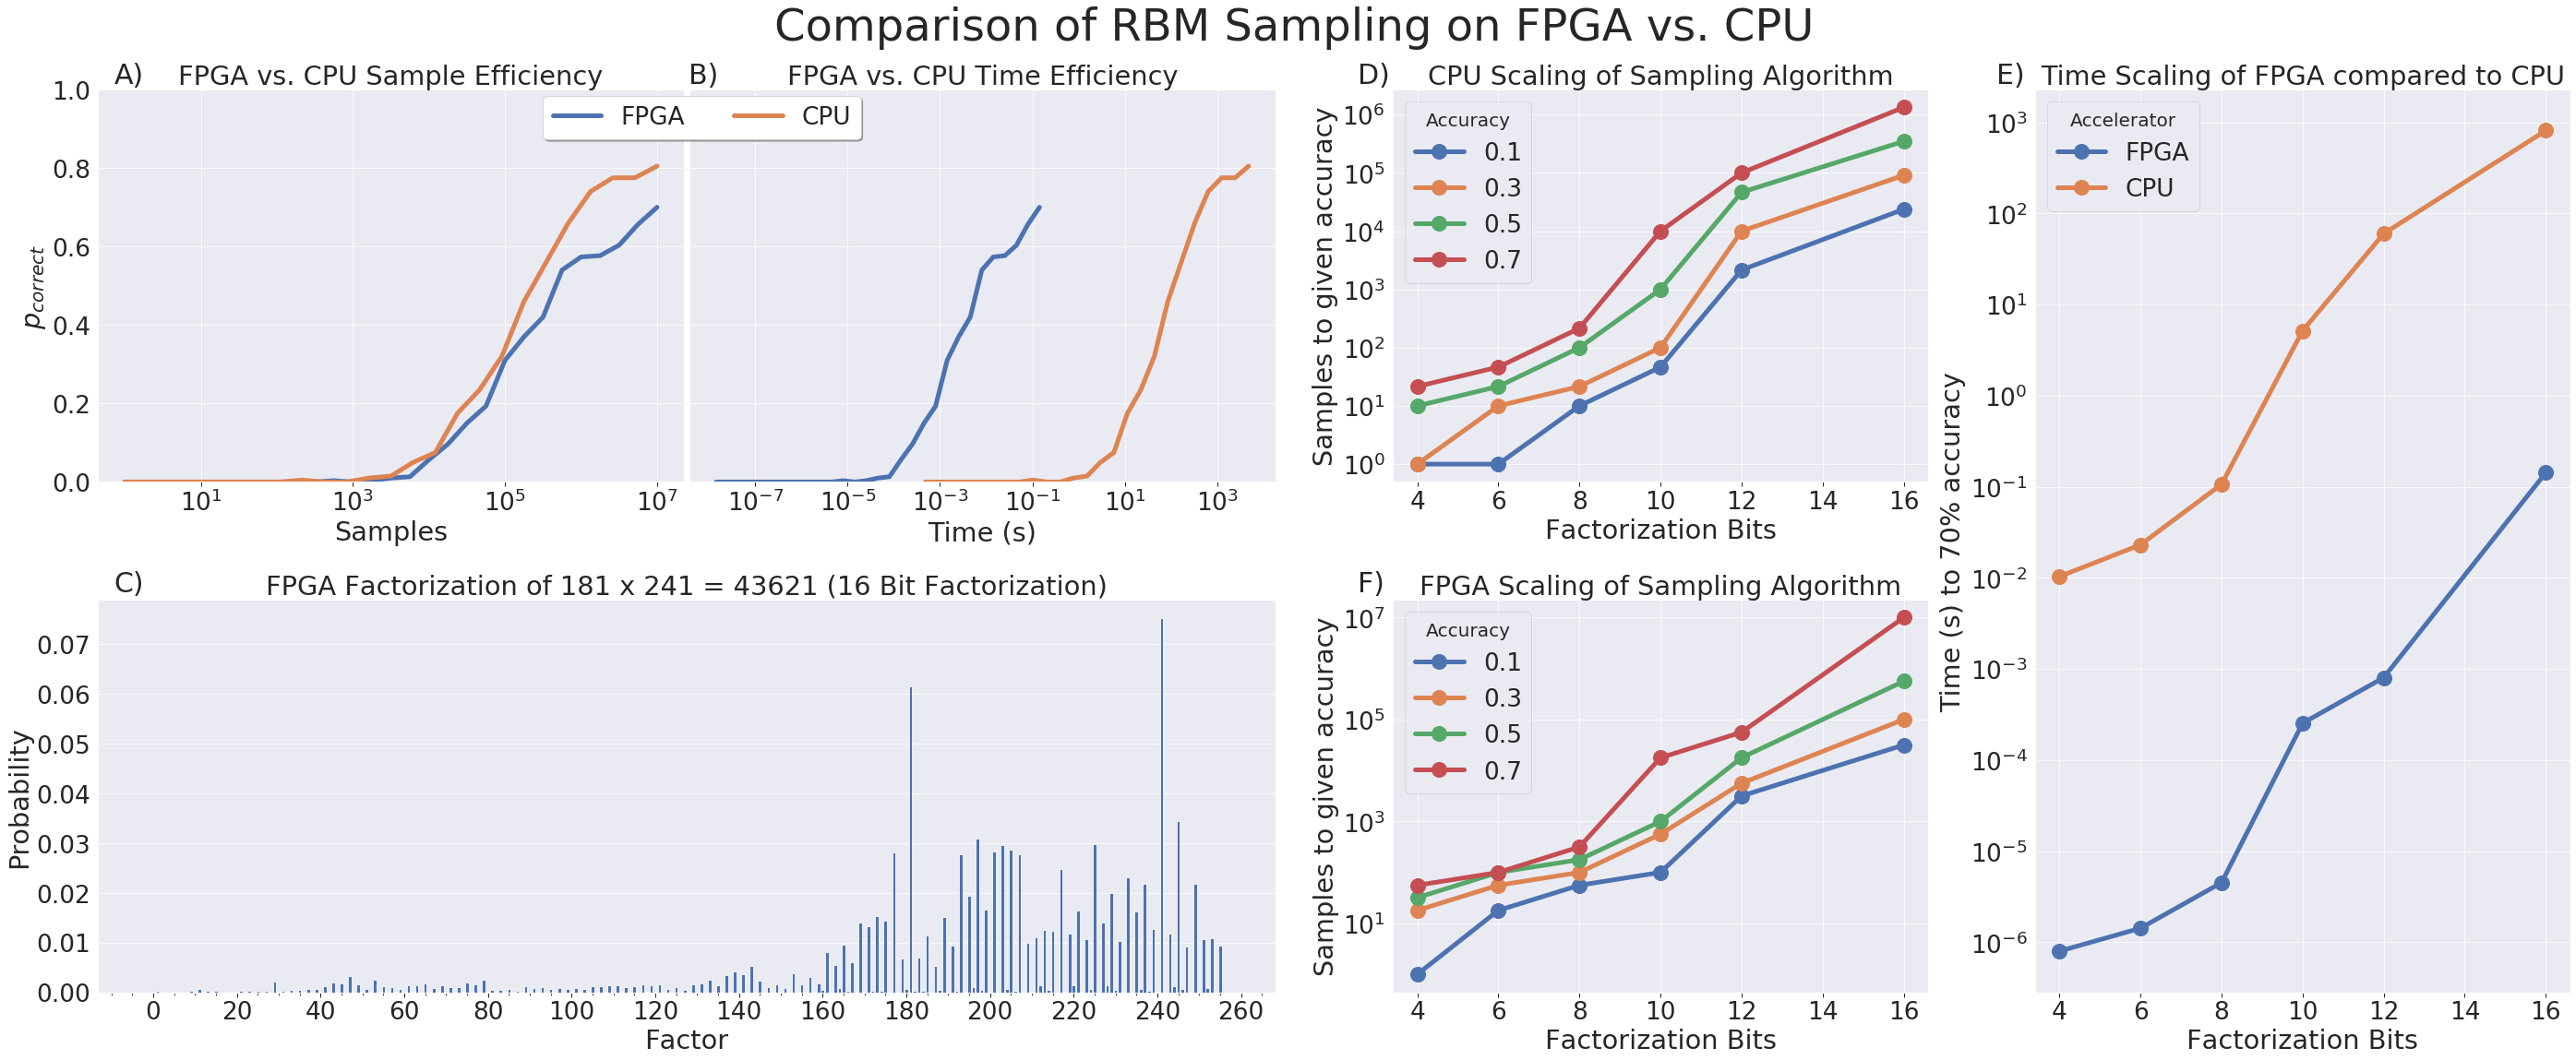

In [43]:
plt.rcParams['font.size'] = 16
caption_size = 30
sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

f = plt.figure(figsize=(48, 18))
supgrid = plt.GridSpec(ncols=2, nrows=1, wspace=0.1, hspace=0.1, figure=f)

#grid = plt.GridSpec(2, 2, wspace=0.01, hspace=0.3, figure=f)
gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, wspace=0.01, hspace=0.3, subplot_spec=supgrid[0])
ax1 = plt.subplot(gs0[0, 0])
ax2 = plt.subplot(gs0[0, 1])
ax3 = plt.subplot(gs0[1, :])


num_cases = 200

with open(homedir + '/../Hardware/outputs/FPGA_corr_200302.p', 'rb') as file:
    FPGA = pickle.load(file)

num_cases_fpga = FPGA['num cases']
    
ax1.set_ylim(0, 1)
ax1.semilogx(FPGA['Samples'], np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax1.semilogx(Mult8_comp_retrain['samples'], retrained[2, :], label='CPU')
ax1.set_ylabel('$p_{correct}$')
ax1.set_xlabel('Samples')
ax1.set_title('FPGA vs. CPU Sample Efficiency')

ax2.set_ylim(0, 1)
ax2.semilogx(FPGA['Samples']*sampT_FPGA, np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax2.semilogx(Mult8_comp_retrain['samples']*sampT_CPU[0], retrained[2, :], label='CPU')
ax2.set_xlabel('Time (s)')
ax2.set_title('FPGA vs. CPU Time Efficiency')

ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])


         
#f.legend(labels=['FPGA', 'CPU'], loc='upper left', bbox_to_anchor=(0.85, 0.88),
#         mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)
handles, labels = ax2.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(0.0, 0.77, 0.44, 0.15), 
         loc='lower center', mode=None, borderaxespad=0, ncol=3, frameon=True, facecolor='white', shadow=True)
#f.legend(labels=['FPGA', 'CPU'])

ax3.bar(np.arange(256), (fact1 + fact2)/(np.sum(fact1 + fact2)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
ax3.set_xlabel('Factor')
ax3.set_ylabel('Probability')
ax3.set_title('FPGA Factorization of {0} x {1} = {2} (16 Bit Factorization)'.format(int(f1), int(f2), int(f1*f2)))
ax3.yaxis.grid(True)
ax3.xaxis.grid(False)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.xaxis.set_major_locator(MultipleLocator(20))



#f = plt.figure(figsize=(24, 18))
#grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3, figure=f)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, wspace=0.2, hspace=0.3, subplot_spec=supgrid[1])

ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[1, 0], sharex=ax1)
ax3 = plt.subplot(gs1[:, 1])

ax1.semilogy(bits, scaling_perf, marker='o', markersize=16)
#plt.semilogy(bits, phase_space, linestyle='--')
#plt.legend(labels=percents + ['Phase Space'], title='Accuracy')
ax1.legend(labels=percents, title='Accuracy', title_fontsize='20')
ax1.set_title('CPU Scaling of Sampling Algorithm')
ax1.set_xlabel('Factorization Bits')
ax1.set_ylabel('Samples to given accuracy')


ax2.semilogy(bits, FPGAscaling_perf, marker='o', markersize=16)
ax2.legend(labels=percents, title='Accuracy', title_fontsize='20')
ax2.set_title('FPGA Scaling of Sampling Algorithm')
ax2.set_xlabel('Factorization Bits')
ax2.set_ylabel('Samples to given accuracy')

ax3.semilogy(bits, FPGAscaling_time[:, -1], marker='o', markersize=16, label='FPGA')
ax3.semilogy(bits, CPUscaling_time[:, -1], marker='o', markersize=16, label='CPU')
ax3.set_title('Time Scaling of FPGA compared to CPU')
ax3.legend(title='Accelerator', title_fontsize='20')
ax3.set_xlabel('Factorization Bits')
ax3.set_ylabel('Time (s) to 70% accuracy')
ax3.set_yticks(np.logspace(-6, 3, 10))

f.suptitle('Comparison of RBM Sampling on FPGA vs. CPU', fontsize=48, y=0.95)


f.text(0.13, 0.885, 'A)', fontsize=caption_size)
f.text(0.31, 0.885, 'B)', fontsize=caption_size)
f.text(0.13, 0.46, 'C)', fontsize=caption_size)
f.text(0.52, 0.885, 'D)', fontsize=caption_size)
f.text(0.72, 0.885, 'E)', fontsize=caption_size)
f.text(0.52, 0.46, 'F)', fontsize=caption_size)
#f.text(0.12, 0.885, 'A)', fontsize=caption_size)
#f.text(0.52, 0.885, 'C)', fontsize=caption_size)
#f.text(0.12, 0.457, 'B)', fontsize=caption_size)
plt.savefig('Fig_FPGACompare.pdf', bbox_inches='tight')



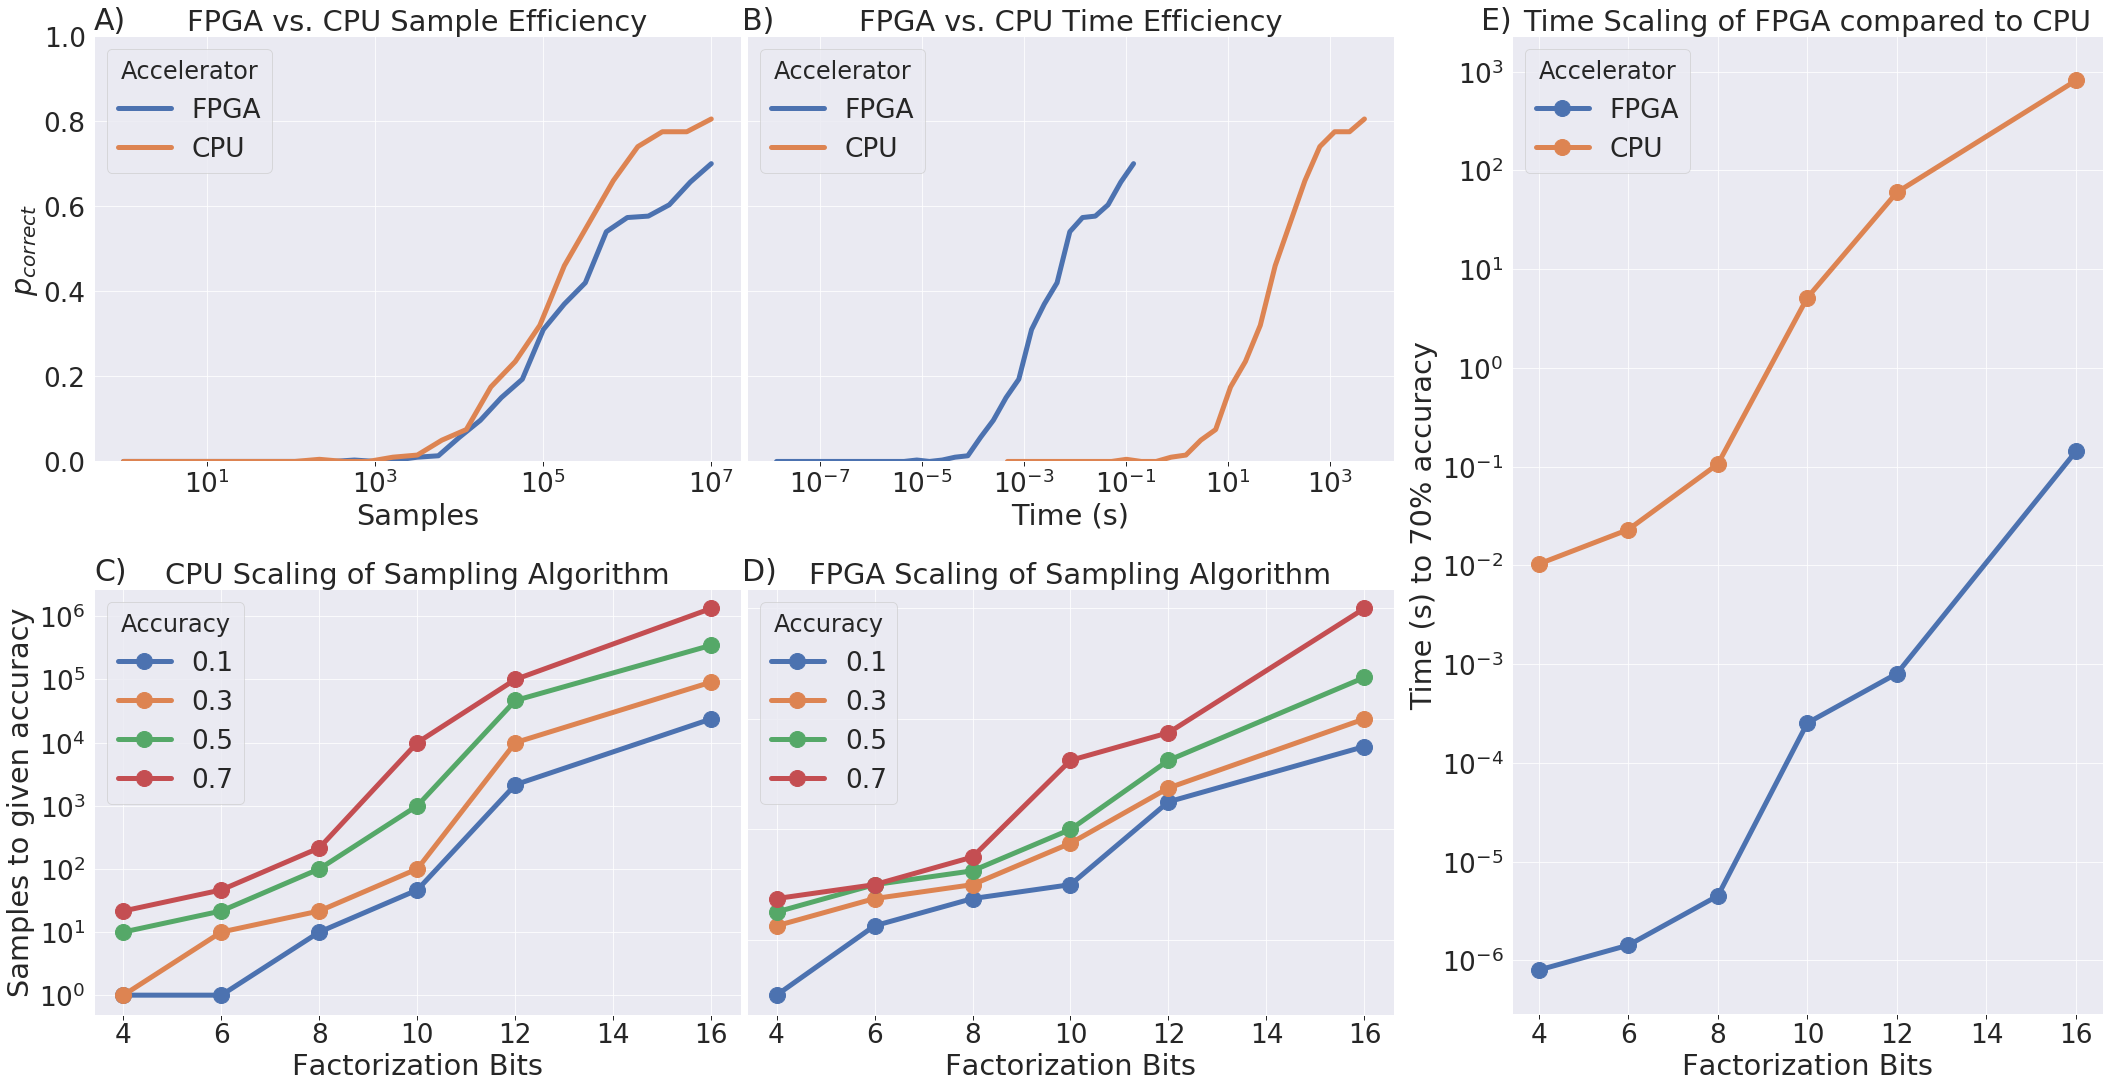

In [44]:
plt.rcParams['font.size'] = 16
caption_size = 30
sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 12, "xtick.minor.size": 8})

f = plt.figure(figsize=(36, 18))
supgrid = plt.GridSpec(ncols=3, nrows=1, wspace=0.2, hspace=0.1, figure=f)

#grid = plt.GridSpec(2, 2, wspace=0.01, hspace=0.3, figure=f)
gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=2, wspace=0.01, hspace=0.3, subplot_spec=supgrid[0:2])
ax1 = plt.subplot(gs0[0, 0])
ax2 = plt.subplot(gs0[0, 1])


num_cases = 200

with open(homedir + '/../Hardware/outputs/FPGA_corr_200302.p', 'rb') as file:
    FPGA = pickle.load(file)

num_cases_fpga = FPGA['num cases']
    
ax1.set_ylim(0, 1)
ax1.semilogx(FPGA['Samples'], np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax1.semilogx(Mult8_comp_retrain['samples'], retrained[2, :], label='CPU')
ax1.set_ylabel('$p_{correct}$')
ax1.set_xlabel('Samples')
ax1.set_title('FPGA vs. CPU Sample Efficiency')
ax1.legend(title='Accelerator', title_fontsize='24')

ax2.set_ylim(0, 1)
ax2.semilogx(FPGA['Samples']*sampT_FPGA, np.array(FPGA['FPGA Correct'])/num_cases_fpga, label='FPGA')
ax2.semilogx(Mult8_comp_retrain['samples']*sampT_CPU[0], retrained[2, :], label='CPU')
ax2.set_xlabel('Time (s)')
ax2.set_title('FPGA vs. CPU Time Efficiency')
ax2.legend(title='Accelerator', title_fontsize='24')

ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])


         
#f.legend(labels=['FPGA', 'CPU'], loc='upper left', bbox_to_anchor=(0.85, 0.88),
#         mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)
# handles, labels = ax2.get_legend_handles_labels()
# f.legend(handles, labels, bbox_to_anchor=(0.0, 0.77, 0.44, 0.15), 
#          loc='lower center', mode=None, borderaxespad=0, ncol=3, frameon=True, facecolor='white', shadow=True)
#f.legend(labels=['FPGA', 'CPU'])


ax3 = plt.subplot(gs0[1, 0])
ax4 = plt.subplot(gs0[1, 1])

ax3.semilogy(bits, scaling_perf, marker='o', markersize=16)
#plt.semilogy(bits, phase_space, linestyle='--')
#plt.legend(labels=percents + ['Phase Space'], title='Accuracy')
ax3.legend(labels=percents, title='Accuracy', title_fontsize='24')
ax3.set_title('CPU Scaling of Sampling Algorithm')
ax3.set_xlabel('Factorization Bits')
ax3.set_ylabel('Samples to given accuracy')


ax4.semilogy(bits, FPGAscaling_perf, marker='o', markersize=16)
ax4.legend(labels=percents, title='Accuracy', title_fontsize='24')
ax4.set_title('FPGA Scaling of Sampling Algorithm')
ax4.set_xlabel('Factorization Bits')

ax3.get_shared_y_axes().join(ax3, ax4)
ax4.set_yticklabels([])

big_ax = plt.subplot(supgrid[2])

big_ax.semilogy(bits, FPGAscaling_time[:, -1], marker='o', markersize=16, label='FPGA')
big_ax.semilogy(bits, CPUscaling_time[:, -1], marker='o', markersize=16, label='CPU')
big_ax.set_title('Time Scaling of FPGA compared to CPU')
big_ax.legend(title='Accelerator', title_fontsize='24')
big_ax.set_xlabel('Factorization Bits')
big_ax.set_ylabel('Time (s) to 70% accuracy')
big_ax.set_yticks(np.logspace(-6, 3, 10))

#f.suptitle('Comparison of RBM Sampling on FPGA vs. CPU', fontsize=48, y=0.95)


f.text(0.125, 0.885, 'A)', fontsize=caption_size)
f.text(0.375, 0.885, 'B)', fontsize=caption_size)
f.text(0.125, 0.46, 'C)', fontsize=caption_size)
f.text(0.375, 0.46, 'D)', fontsize=caption_size)
f.text(0.66, 0.885, 'E)', fontsize=caption_size)


plt.savefig('Fig_FPGACompare(2).pdf', bbox_inches='tight')

Text(0.125, 0.455, 'D)')

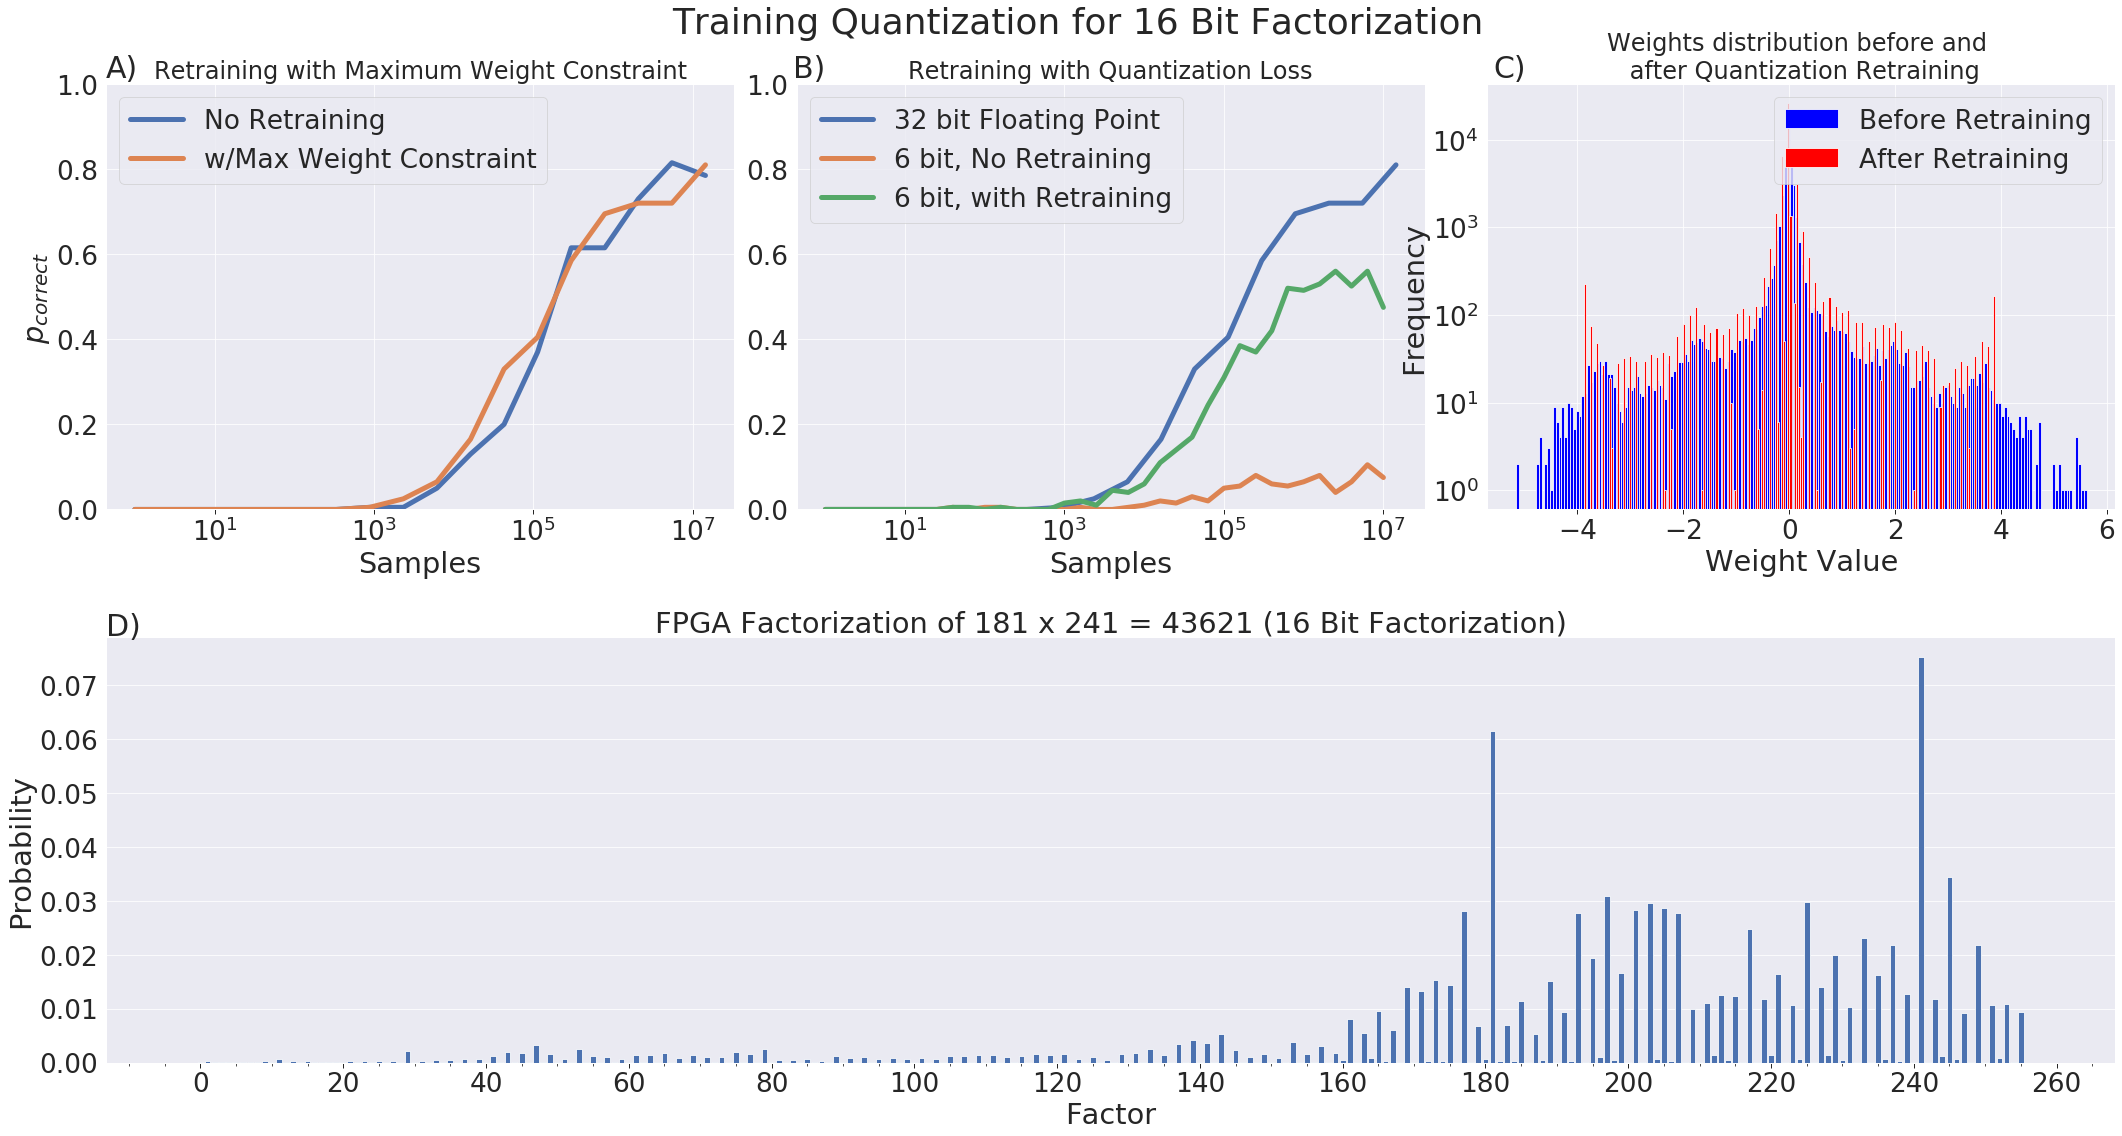

In [45]:
f = plt.figure(figsize=(36, 18))
#supgrid = plt.GridSpec(ncols=1, nrows=2, wspace=0.1, hspace=0.1, figure=f)
#grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3, figure=f)


#gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=2, wspace=0.1, hspace=0.2, subplot_spec=supgrid[0])
gs0 = plt.GridSpec(ncols=3, nrows=2, wspace=0.1, hspace=0.3, figure=f)
ax1 = plt.subplot(gs0[0, 0])
ax2 = plt.subplot(gs0[0, 1], sharey=ax1)
ax3 = plt.subplot(gs0[0, 2])
ax4 = plt.subplot(gs0[1, :])


M8_retrain = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-max4-quant-retrain.p')
M8 = RBM.load(homedir + '/LogicRBM/trained/Mult8-Mult4-retrain.p')

titlesize = 24

sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})


#f, ((tax1, tax2), (bax1, bax2)) = plt.subplots(2, 2, sharey='row', figsize=(24, 16), dpi=200)
#f.subplots_adjust(wspace=0.01, hspace=0.3)

ax1.set_ylim(0, 1)
ax1.semilogx(M8M4['samples'][:-2], M8M4['Mult8-Mult4-retrain'][2, :][:-2], label='No Retraining')
ax1.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='w/Max Weight Constraint')
ax1.set_title('Retraining with Maximum Weight Constraint', fontsize=titlesize)
ax1.set_xlabel('Samples')
ax1.set_ylabel('$p_{correct}$')
ax1.legend()

ax2.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='32 bit Floating Point')
ax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p'][2, :], label='6 bit, No Retraining')
ax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p-retrain'][2, :], label='6 bit, with Retraining')
ax2.legend()
ax2.set_xlabel('Samples')
ax2.set_title('Retraining with Quantization Loss', fontsize=titlesize)


ax3.hist(M8.weights.numpy().flatten(), color = 'blue', bins=200, log=True, label='Before Retraining')
ax3.set_xlabel('Weight Value')
ax3.set_ylabel('Frequency')
ax3.set_title('Weights distribution before Retraining', fontsize=titlesize)

ax3.hist(M8_retrain.weights.numpy().flatten(), color = 'red', bins=200, log=True, label='After Retraining')
ax3.set_xlabel('Weight Value')
ax3.set_title('Weights distribution before and \n after Quantization Retraining', fontsize=titlesize)
ax3.legend()
f.suptitle('Training Quantization for 16 Bit Factorization', y=0.94, fontsize=36)

ax4.bar(np.arange(256), (fact1 + fact2)/(np.sum(fact1 + fact2)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
ax4.set_xlabel('Factor')
ax4.set_ylabel('Probability')
ax4.set_title('FPGA Factorization of {0} x {1} = {2} (16 Bit Factorization)'.format(int(f1), int(f2), int(f1*f2)))
ax4.yaxis.grid(True)
ax4.xaxis.grid(False)
ax4.xaxis.set_minor_locator(MultipleLocator(5))
ax4.xaxis.set_major_locator(MultipleLocator(20))


f.text(0.125, 0.885, 'A)', fontsize=caption_size)
f.text(0.39, 0.885, 'B)', fontsize=caption_size)
f.text(0.66, 0.885, 'C)', fontsize=caption_size)
f.text(0.125, 0.455, 'D)', fontsize=caption_size)




In [46]:
'''
This initializes all of the data for the next plot

'''

with open(homedir + '/LogicRBM/outputs/comparisons/Mult8-Variability-long_200109_1.p', 'rb') as f:
    Mult8_comp_retrain = pickle.load(f)
    
with open(homedir + '/LogicRBM/outputs/comparisons/Mult8_new_200409_0.p', 'rb') as f:
    Mult8_new = pickle.load(f)

with open(homedir + '/LogicRBM/outputs/Mult8-long.p', 'rb') as f:
    Mult8_long = pickle.load(f)
Mult8_dict = Mult8_long['out_dict']
f1_CPU = Mult8_long['factor1']
f2_CPU = Mult8_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])

sns.set_style('dark', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

fact1_CPU = np.zeros(256)
fact2_CPU = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1_CPU[a] += val
    fact2_CPU[b] += val
    
    

with open(homedir + '/../Hardware/outputs/Mult8-FPGA.p', 'rb') as f:
    Mult8_FPGA_long = pickle.load(f)
Mult8_dict = Mult8_FPGA_long['out_dict']
f1_FPGA = Mult8_FPGA_long['factor1']
f2_FPGA = Mult8_FPGA_long['factor2']
v = list(Mult8_dict[0].items())
vals = [x[1] for x in v]
MLE = v[np.argmax(vals)]
MLE = (utils.fromBuffer(MLE[0]), MLE[1])

sns.set_style('dark', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})

fact1_FPGA = np.zeros(256)
fact2_FPGA = np.zeros(256)
for key, val in v:
    a, b, _ = list(map(int, utils.MultToVals(utils.fromBuffer(key))))
    fact1_FPGA[a] += val
    fact2_FPGA[b] += val

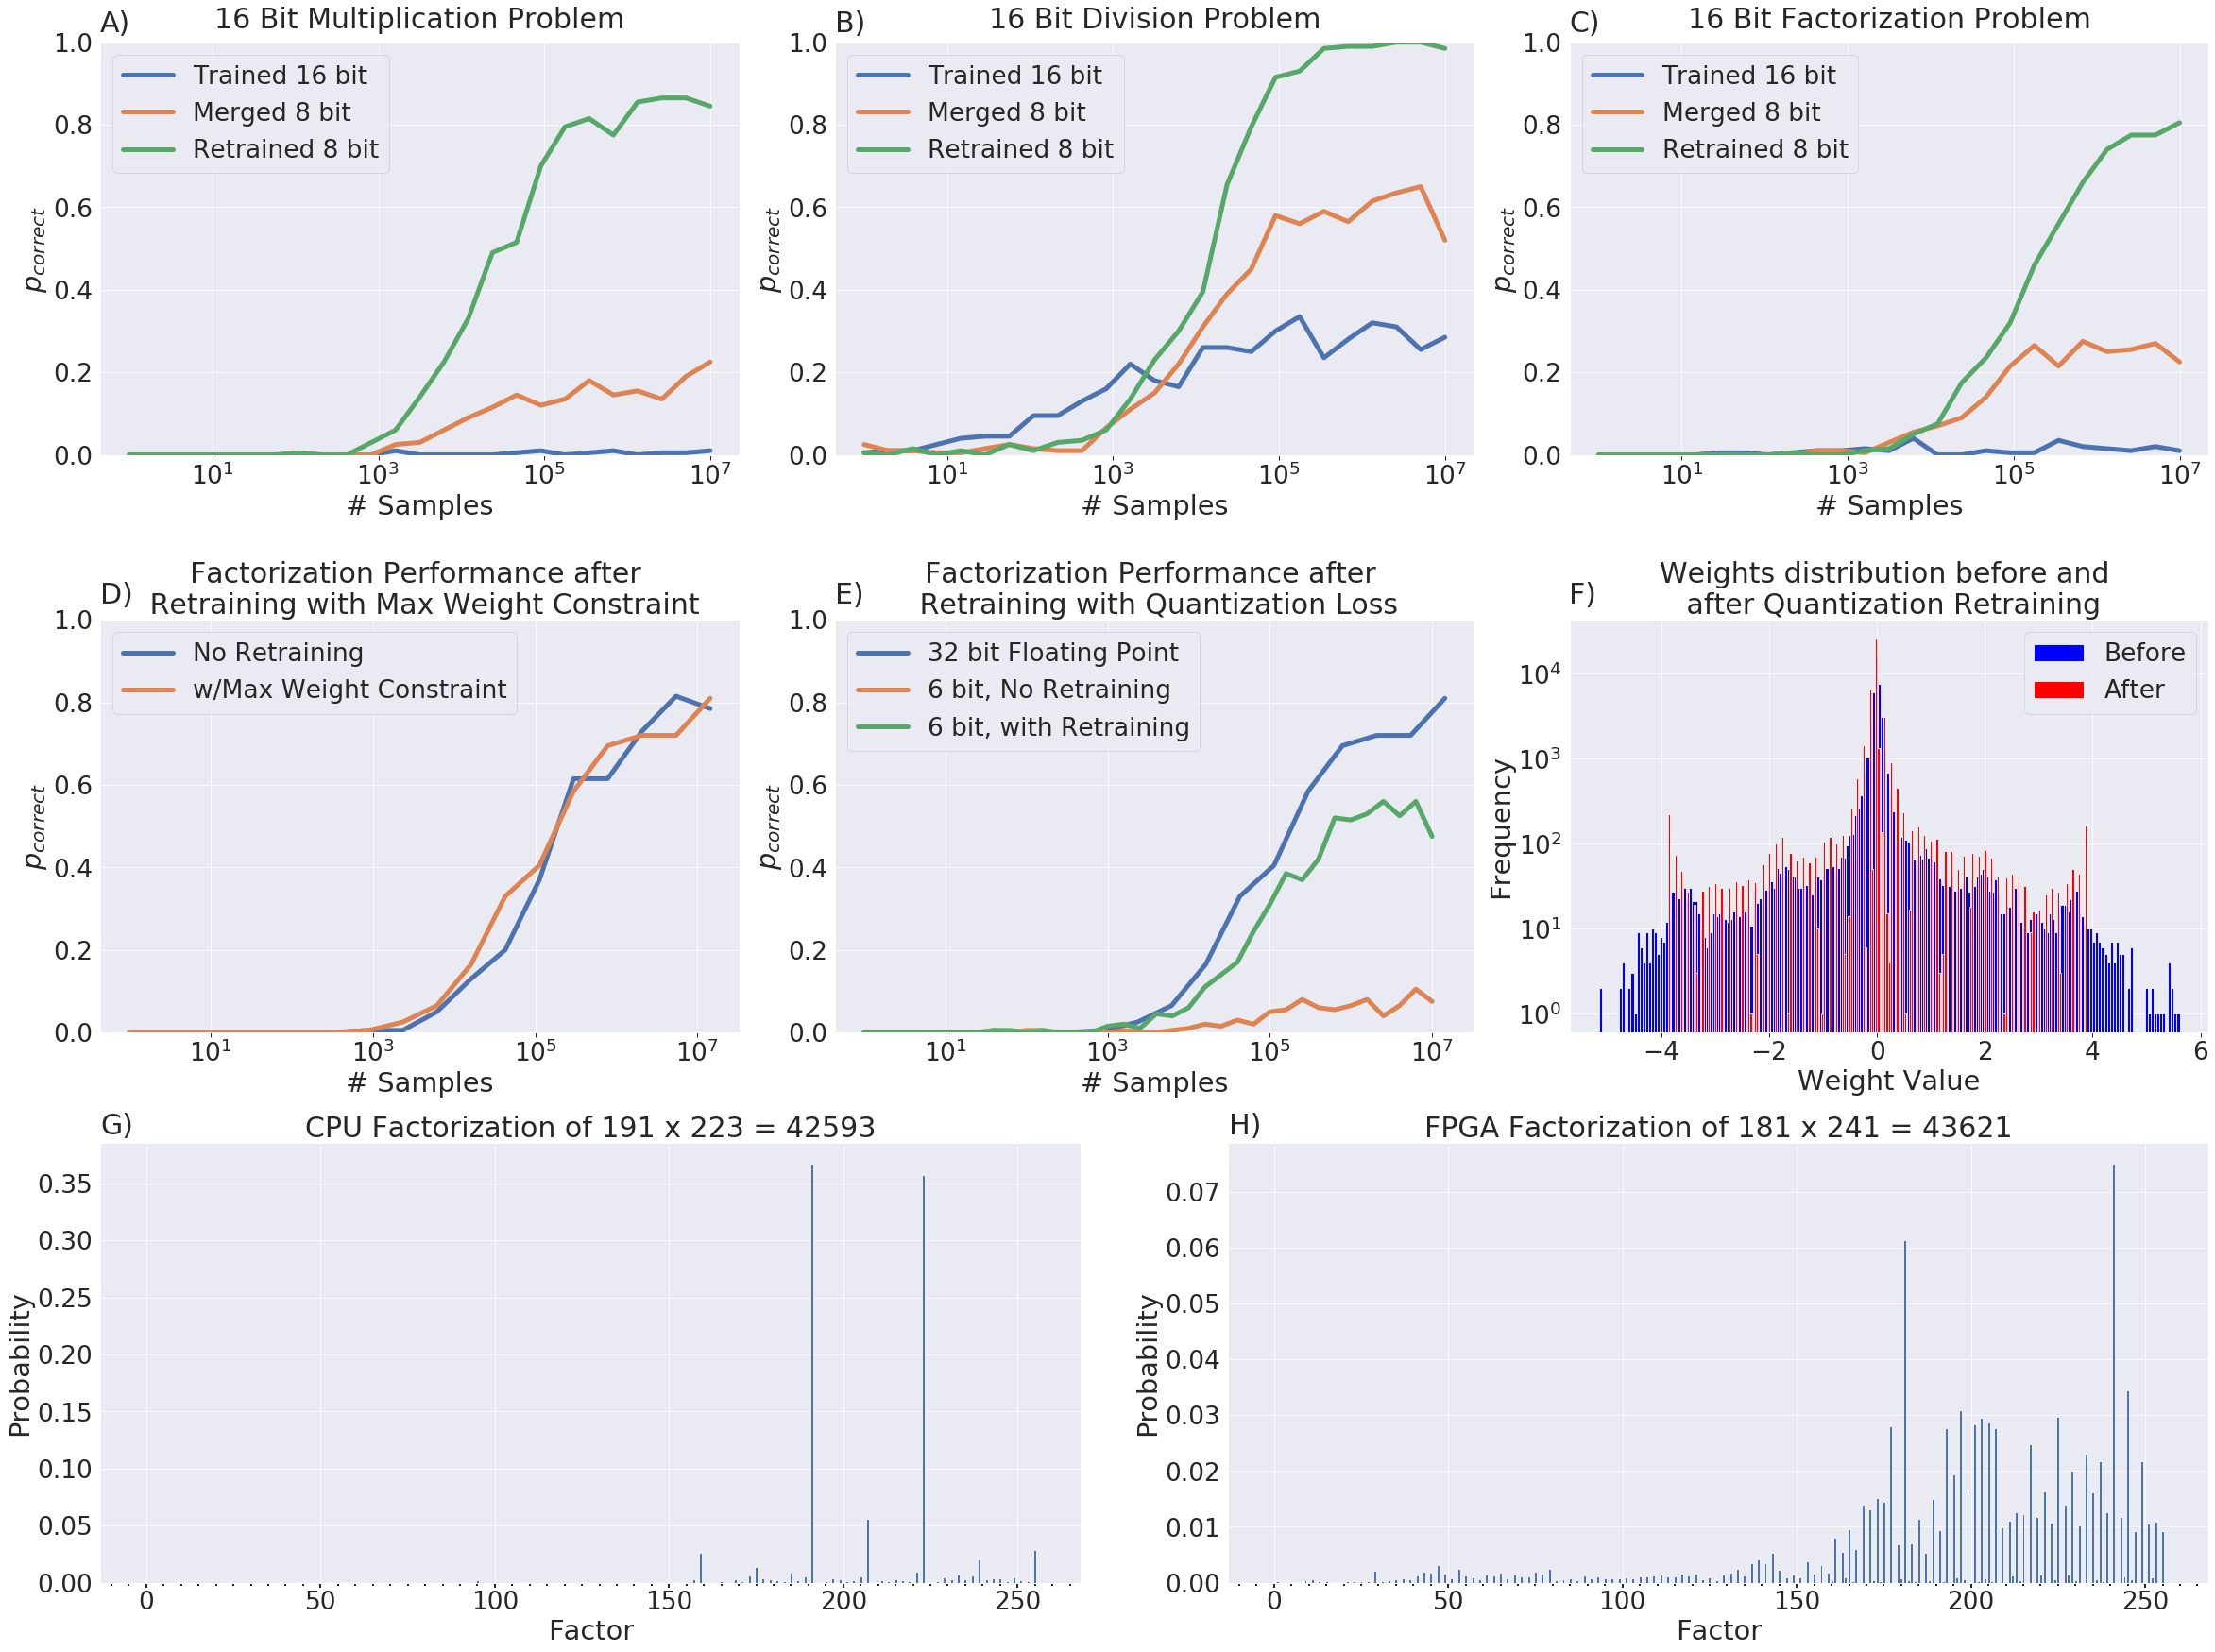

In [47]:
plt.rcParams['lines.linewidth'] = 5.0
plt.rcParams['font.size'] = 24

caption_size = 30
titlesize = 30
sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 12, "xtick.minor.size": 6})


f = plt.figure(figsize=(40, 30))

supgrid = plt.GridSpec(ncols=1, nrows=3, wspace=0.15, hspace=0.25, figure=f)

tgrid = matplotlib.gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=2, wspace=0.15, hspace=0.4, subplot_spec=supgrid[0:2])
#grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3, figure=f)

tax1 = plt.subplot(tgrid[0, 0])
tax2 = plt.subplot(tgrid[0, 1], sharey=tax1)
tax3 = plt.subplot(tgrid[0, 2], sharey=tax1)
bax1 = plt.subplot(tgrid[1, 0])
bax2 = plt.subplot(tgrid[1, 1], sharey=bax1)
bax3 = plt.subplot(tgrid[1, 2])

gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, wspace=0.15, hspace=0.02, subplot_spec=supgrid[2])
#gs0 = plt.GridSpec(ncols=2, nrows=1, wspace=0.1, hspace=0.3, figure=f)


fact_ax1 = plt.subplot(gs0[0])
fact_ax2 = plt.subplot(gs0[1])


#f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(32, 8), dpi=200)
#f.subplots_adjust(wspace=0.01, hspace=0.6)


samps = Mult8_comp_retrain['samples']
merged = np.array(Mult8_comp_retrain['Mult8-Mult4'])
#retrained = np.array(Mult8_new['8BitMergeMult_200320_2'])
retrained = np.array(Mult8_comp_retrain['Mult8-Mult4-retrain'])
trained = np.array(Mult8_comp_retrain['Mult8'])
ax1.set_ylim(0, 1)

tax1.semilogx(samps, trained[0, :])
tax1.semilogx(samps, merged[0, :])
tax1.semilogx(samps, retrained[0, :])
#ax1.semilogx(Mult8_new['samples'], retrained[0, :])

tax1.set_title('16 Bit Multiplication Problem', y=1.02, fontsize=titlesize)
tax1.set_ylabel('$p_{correct}$')
tax1.set_xlabel('# Samples')


tax2.set_ylim(0, 1)
tax2.semilogx(samps, trained[1, :])
tax2.semilogx(samps, merged[1, :])
tax2.semilogx(samps, retrained[1, :])
tax2.set_title('16 Bit Division Problem', y=1.02, fontsize=titlesize)
tax2.set_ylabel('$p_{correct}$')
tax2.set_xlabel('# Samples')


tax3.set_ylim(0, 1)
tax3.semilogx(samps, trained[2, :])
tax3.semilogx(samps, merged[2, :])
tax3.semilogx(samps, retrained[2, :])
tax3.set_title('16 Bit Factorization Problem', y=1.02, fontsize=titlesize)
tax3.set_ylabel('$p_{correct}$')
tax3.set_xlabel('# Samples')


# tax2.legend(labels=['Trained 16 bit', 'Merged 8 bit', 'Retrained 8 bit'], bbox_to_anchor=(0.0, 0.62, 0.71, .15), 
#          loc='lower center', mode=None, borderaxespad=0, ncol=1, frameon=True, facecolor='white', shadow=True)
tax1.legend(labels=['Trained 16 bit', 'Merged 8 bit', 'Retrained 8 bit'])
tax2.legend(labels=['Trained 16 bit', 'Merged 8 bit', 'Retrained 8 bit'])
tax3.legend(labels=['Trained 16 bit', 'Merged 8 bit', 'Retrained 8 bit'])




bax1.set_ylim(0, 1)
bax1.semilogx(M8M4['samples'][:-2], M8M4['Mult8-Mult4-retrain'][2, :][:-2], label='No Retraining')
bax1.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='w/Max Weight Constraint')
bax1.set_title('Factorization Performance after \n Retraining with Max Weight Constraint', fontsize=titlesize)
bax1.set_xlabel('# Samples')
bax1.set_ylabel('$p_{correct}$')
bax1.legend()

bax2.semilogx(M8M4_max4['samples'][:-2], M8M4_max4['Mult8-Mult4-max4-retrain'][2, :][:-2], label='32 bit Floating Point')
bax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p'][2, :], label='6 bit, No Retraining')
bax2.semilogx(quant_compare['samples'], quant_compare['Mult8-Mult4-6b3p-retrain'][2, :], label='6 bit, with Retraining')
bax2.legend()
bax2.set_xlabel('# Samples')
bax2.set_ylabel('$p_{correct}$')
bax2.set_title('Factorization Performance after \n Retraining with Quantization Loss', fontsize=titlesize)


bax3.hist(M8.weights.numpy().flatten(), color = 'blue', bins=200, log=True, label='Before')
bax3.hist(M8_retrain.weights.numpy().flatten(), color = 'red', bins=200, log=True, label='After')
bax3.set_xlabel('Weight Value')
bax3.set_ylabel('Frequency')
bax3.set_title('Weights distribution before and \n after Quantization Retraining', fontsize=titlesize)
bax3.legend()




fact_ax1.bar(np.arange(256), (fact1_CPU + fact2_CPU)/(np.sum(fact1_CPU + fact2_CPU)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
fact_ax1.set_xlabel('Factor')
fact_ax1.set_ylabel('Probability')
fact_ax1.set_title('CPU Factorization of {0} x {1} = {2}'.format(int(f1_CPU), int(f2_CPU), int(f1_CPU*f2_CPU)), fontsize=titlesize)
fact_ax1.yaxis.grid(True)
fact_ax1.xaxis.set_minor_locator(MultipleLocator(5))
fact_ax1.xaxis.set_tick_params(which='minor', width=2)
fact_ax1.xaxis.set_tick_params(which='major', width=2)




fact_ax2.bar(np.arange(256), (fact1_FPGA + fact2_FPGA)/(np.sum(fact1_FPGA + fact2_FPGA)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
fact_ax2.set_xlabel('Factor')
fact_ax2.set_ylabel('Probability')
fact_ax2.set_title('FPGA Factorization of {0} x {1} = {2}'.format(int(f1_FPGA), int(f2_FPGA), int(f1_FPGA*f2_FPGA)), fontsize=titlesize)
fact_ax2.yaxis.grid(True)
fact_ax2.xaxis.set_minor_locator(MultipleLocator(5))
fact_ax2.xaxis.set_tick_params(which='minor', width=2)
fact_ax2.xaxis.set_tick_params(which='major', width=2)

f.text(0.125, 0.885, 'A)', fontsize=caption_size)
f.text(0.395, 0.885, 'B)', fontsize=caption_size)
f.text(0.665, 0.885, 'C)', fontsize=caption_size)
f.text(0.125, 0.605, 'D)', fontsize=caption_size)
f.text(0.395, 0.605, 'E)', fontsize=caption_size)
f.text(0.665, 0.605, 'F)', fontsize=caption_size)
f.text(0.125, 0.345, 'G)', fontsize=caption_size)
f.text(0.54, 0.345, 'H)', fontsize=caption_size)
#f.suptitle('Training RBMs to Accelerate Factorization', y=0.93, fontsize=48)
plt.savefig('Fig_RBMTrain.pdf', bbox_inches='tight')

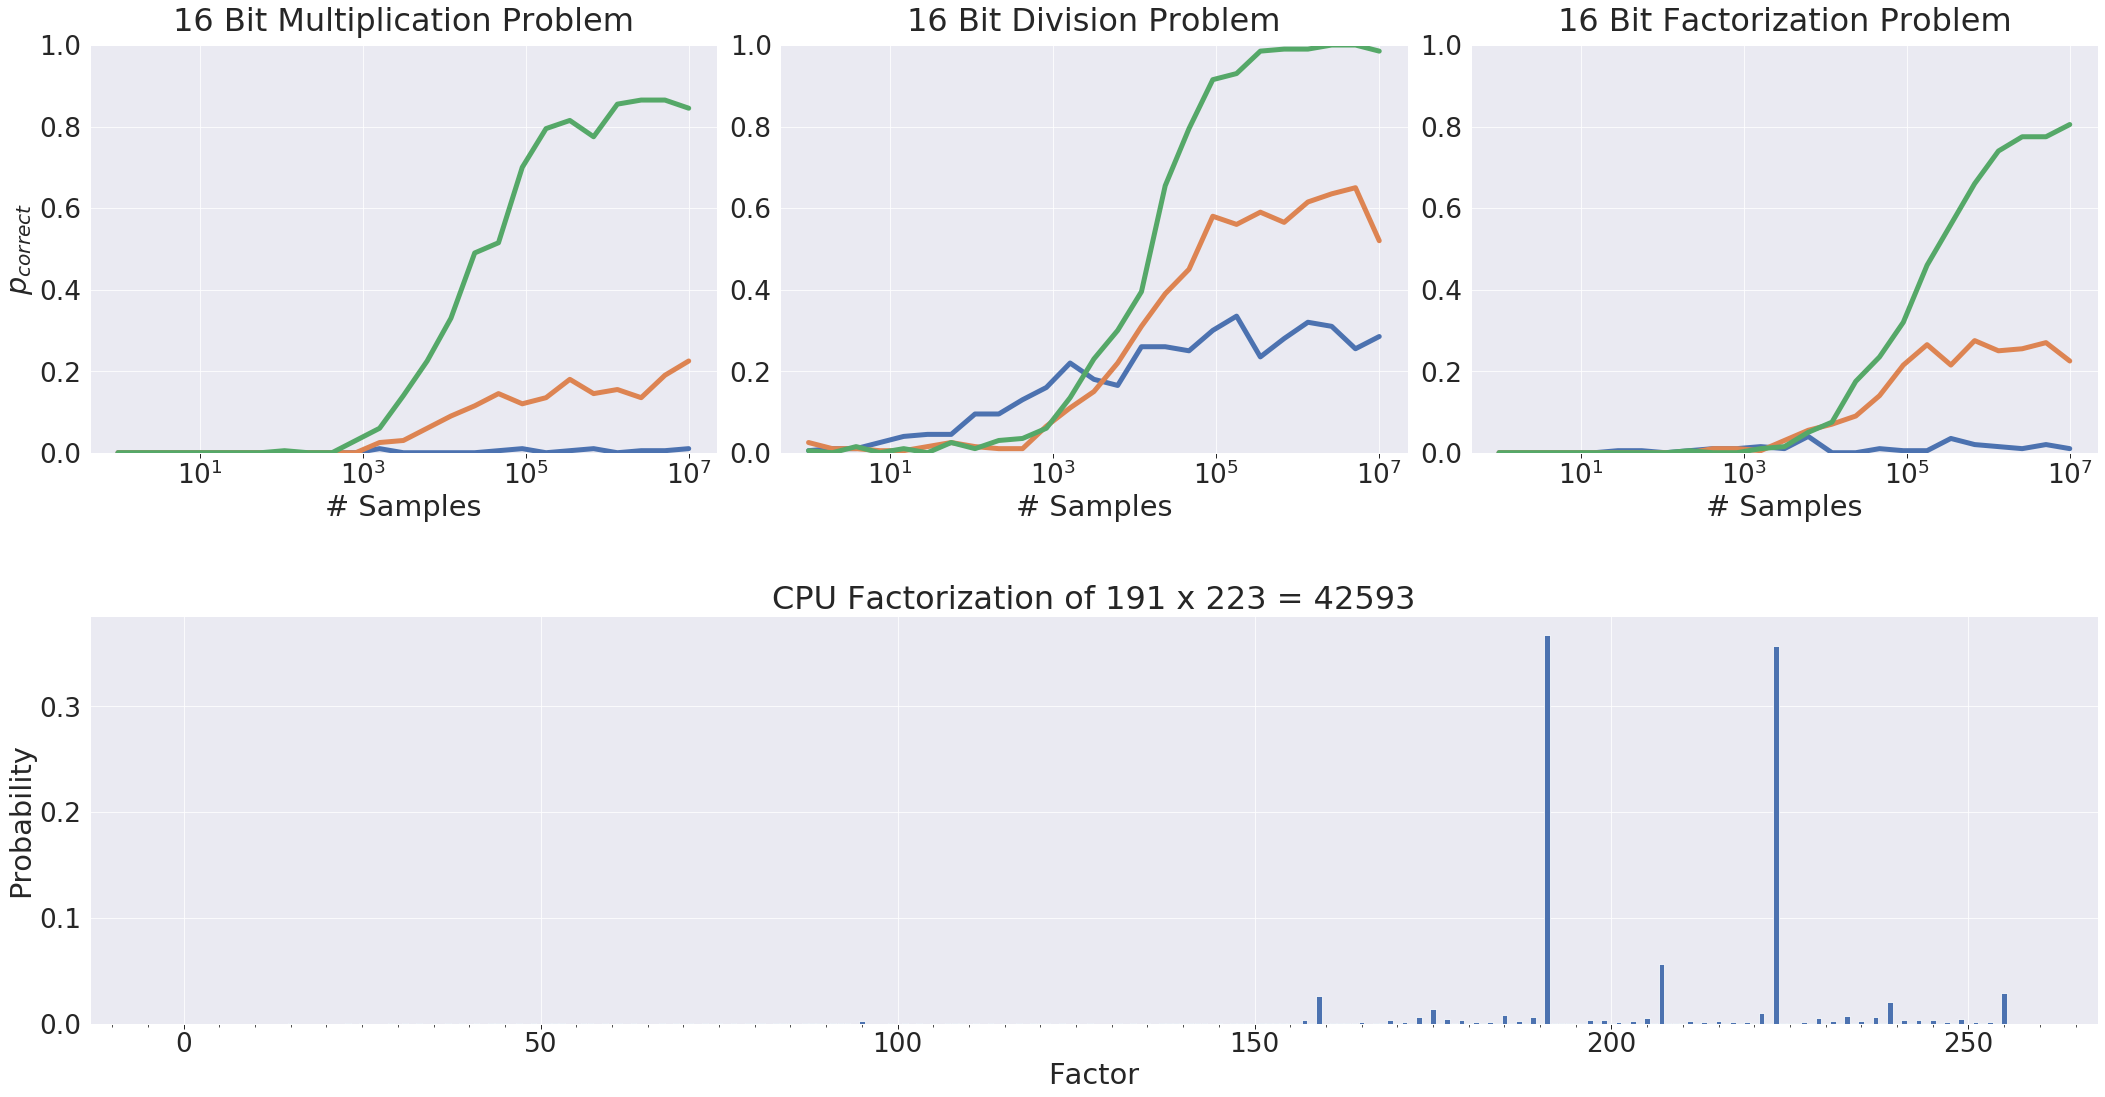

In [48]:
plt.rcParams['lines.linewidth'] = 5.0
plt.rcParams['font.size'] = 24

caption_size = 30
titlesize = 32
sns.set_style('darkgrid', {'xtick.bottom': True, "xtick.major.size": 6, "xtick.minor.size": 3})


f = plt.figure(figsize=(36, 18))


tgrid = plt.GridSpec(ncols=3, nrows=2, wspace=0.1, hspace=0.4, figure=f)
#grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3, figure=f)

tax1 = plt.subplot(tgrid[0, 0])
tax2 = plt.subplot(tgrid[0, 1], sharey=tax1)
tax3 = plt.subplot(tgrid[0, 2], sharey=tax1)



fact_ax1 = plt.subplot(tgrid[1, :])

#f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(32, 8), dpi=200)
#f.subplots_adjust(wspace=0.01, hspace=0.6)


samps = Mult8_comp_retrain['samples']
merged = np.array(Mult8_comp_retrain['Mult8-Mult4'])
#retrained = np.array(Mult8_new['8BitMergeMult_200320_2'])
retrained = np.array(Mult8_comp_retrain['Mult8-Mult4-retrain'])
trained = np.array(Mult8_comp_retrain['Mult8'])
ax1.set_ylim(0, 1)

tax1.semilogx(samps, trained[0, :])
tax1.semilogx(samps, merged[0, :])
tax1.semilogx(samps, retrained[0, :])
tax1.set_ylabel('$p_{correct}$')
tax1.set_title('16 Bit Multiplication Problem', y=1.02, fontsize=titlesize)
tax1.set_xlabel('# Samples')


tax2.set_ylim(0, 1)
tax2.semilogx(samps, trained[1, :])
tax2.semilogx(samps, merged[1, :])
tax2.semilogx(samps, retrained[1, :])
tax2.set_title('16 Bit Division Problem', y=1.02, fontsize=titlesize)
tax2.set_xlabel('# Samples')


tax3.set_ylim(0, 1)
tax3.semilogx(samps, trained[2, :])
tax3.semilogx(samps, merged[2, :])
tax3.semilogx(samps, retrained[2, :])
tax3.set_title('16 Bit Factorization Problem', y=1.02, fontsize=titlesize)
tax3.set_xlabel('# Samples')

fact_ax1.bar(np.arange(256), (fact1_CPU + fact2_CPU)/(np.sum(fact1_CPU + fact2_CPU)))
#plt.axvline(x=f1, color='r', ls='--', linewidth=1)
#plt.axvline(x=f2, color='r', ls='--', linewidth=1)
fact_ax1.set_xlabel('Factor')
fact_ax1.set_ylabel('Probability')
fact_ax1.set_title('CPU Factorization of {0} x {1} = {2}'.format(int(f1_CPU), int(f2_CPU), int(f1_CPU*f2_CPU)), fontsize=titlesize)
fact_ax1.yaxis.grid(True)
fact_ax1.xaxis.set_minor_locator(MultipleLocator(5))
